# Deep Learning assignment #1

***Student:*** [Isac Pasianotto](https://github.com/IsacPasianotto/dlhw)

***Table of contents:***

0. [Dataset definition](#0.-Dataset-definition)
1. [Network definition](#1.-Network-definition)
    - [Training the network, storing the weights and the losses](#1.1-Training-the-network,-storing-the-weights-and-the-losses)
    - [Plotting the results](#1.2-Plotting-the-results)
2. [Perform the experiment](#2-Perform-the-experiment)
    - [Original formulation](#2.1-Original-formulation)
    - [Balanced dataset](#2.2-Balanced-dataset)
    - [Varying the Learning Rate](#2.3-Varying-the-Learning-Rate)
    - [Varying the number of hidden neurons](#2.4-Varying-the-number-of-hidden-neurons)
    - [Varying the loss function](#2.5-Varying-the-loss-function)
    - [Varying the activation function](#2.6-Varying-the-activation-function)
    - [Varying the optimizer](#2.7-Varying-the-optimizer)

In [1]:
import torch
from typing import Iterable, List, Tuple
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
import matplotlib.pyplot as plt
import os as os

# make a dir to save the plots
if not os.path.exists('./images'):
    os.makedirs('./images')

In [2]:
# Some constants
STD_DTYPE = torch.float32  # Note, some functions may not work with float16 :(
N_DIGITS = 6
N_HIDDEN = 2
N_HEPOCHS = 1425
IMG_DIR = './images'

## 0. Dataset definition

The considered dataset is the set of all possible 6-bit long binary sequences. Since the task the network is supposed to perform is to check if a given sequence is palindromic, the dataset is labeled accordingly.

In [3]:
def is_symmetric(iterable: Iterable) -> float:
    """
    Check if an iterable is palindromic.
    :param iterable: an iterable object to check (in our case, a torch tensor)
    :return: 1 if the iterable is palindromic, 0 otherwise
    """
    return 1. if all(a == b for a, b in zip(iterable, reversed(iterable))) else 0.

# Ensure that the function works as expected
assert is_symmetric( torch.tensor([0, 1, 0, 1, 1, 0]) ) == 0.
assert is_symmetric( torch.tensor([0, 1, 0, 0, 1, 0]) ) == 1.

In [4]:
bin_seq: List[Tensor] = list(product([0, 1], repeat=N_DIGITS))
sim_true: List[Tensor] = [seq for seq in bin_seq if is_symmetric(seq)]
sim_false: List[Tensor] = [seq for seq in bin_seq if not is_symmetric(seq)]

sim_true_tensor: Tensor = torch.tensor(sim_true, dtype=STD_DTYPE)
sim_false_tensor: Tensor = torch.tensor(sim_false, dtype=STD_DTYPE)
y_sim_true_tensor: Tensor = torch.ones((len(sim_true), 1), dtype=STD_DTYPE)
y_sim_false_tensor: Tensor = torch.zeros((len(sim_false), 1), dtype=STD_DTYPE)

x: Tensor = torch.cat((sim_false_tensor, sim_true_tensor), dim=0)
y: Tensor = torch.cat((y_sim_false_tensor, y_sim_true_tensor), dim=0)

balancing_ratio: int = len(sim_false) // len(sim_true)
x_balanced: Tensor = torch.cat((sim_false_tensor, sim_true_tensor.repeat(balancing_ratio, 1)), dim=0)
y_balanced: Tensor = torch.cat((y_sim_false_tensor, y_sim_true_tensor.repeat(balancing_ratio, 1)), dim=0)


In [5]:
train_tds: TensorDataset = TensorDataset(x, y)
train_balanced_tds: TensorDataset = TensorDataset(x_balanced, y_balanced)

# Putting batch_size = # of elements will make the algorithm perform GD instead of SGD
train_tdl: DataLoader = DataLoader(train_tds, batch_size=len(train_tds), shuffle=True)
train_balanced_tdl: DataLoader = DataLoader(train_balanced_tds, batch_size=len(train_balanced_tds), shuffle=True)

## 1. Network definition

The considered paper is quite cryptic regarding all the needed information to reproduce exactly the experiment. From that I have evinced that:
- The input layer has 6 neurons, one for each bit of the input sequence.
- There is just 1 hidden layer with 2 neurons.
- The output layer has 1 neuron, which is the output of the network.

Hence, we can re-draw the *Fig. 1* of the paper with a more conventional representation as:  

<center><img src="./images/img-00.png" style="width: 35%;"/></center>

Moreover, there is specified that: 
- The initial weights are randomly drawn from a uniform distribution in the range [-0.3, 0.3].
- The gradient descent algorithm was not stochastic, all the dataset was used to compute the gradient.
- The loss function used (called "Error" in the paper) is $\frac{1}{2}\sum_{c}\sum_{j}{\left( y_{i,c} - d_{i, c} \right)^2}$
- The train lasted for 1,425 epochs.
- The learning rate was $\varepsilon = 0.1$.


What is not specified is: 

- The activation function used in the hidden layer. The only mentioned non-linear function in the paper is $y_i = \frac{1}{1+e^{-x_i}}$ which is the sigmoid function and is already implemented in [PyTorch](https://pytorch.org/docs/stable/generated/https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.htmll).
- The initialization of the bias terms. I will assume that they are initialized to 0.

In [6]:
class paper_net(torch.nn.Module):
    """
    The network as described in the paper. Class which extends torch.nn.Module.
    """
    
    def __init__(self, input_size: int = N_DIGITS, hidden_size: int = 2, func: torch.nn.Module = torch.nn.Sigmoid(), dtype: torch.dtype = STD_DTYPE):
        """
        Initialize the network object.
        :param input_size: the size of the input layer. Should be equal to te number of bits of the input sequence. Default is 6.
        :param hidden_size: the size of the hidden layer. Default is 2.
        :param func: the activation function to use in the hidden layer. Default is torch.nn.Sigmoid.
        :param dtype: the data type of the tensors. Default is torch.float32.
        """
        super(paper_net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = 1
        self.act_fun = func
        self.dtype = dtype
        self.w_min = -0.3
        self.w_max = 0.3
        self.b = 0.
        
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size, dtype=dtype)
        self.output = torch.nn.Linear(self.hidden_size, self.out_size, dtype=dtype)
        
        with torch.no_grad():
            # Weights initialization
            torch.nn.init.uniform_(self.hidden.weight,self.w_min, self.w_max)
            torch.nn.init.uniform_(self.output.weight,self.w_min, self.w_max)
            # Bias initialization
            torch.nn.init.constant_(self.hidden.bias, self.b)
            torch.nn.init.constant_(self.output.bias, self.b)
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the network.
        :param x: the input tensor.
        :return: the output tensor.
        """
        x = self.act_fun(self.hidden(x))
        x = torch.sigmoid_(self.output(x))
        return x

In [7]:
def loss_fn(y_pred: Tensor, y_true: Tensor) -> Tensor:
    """
    Compute the loss function.
    :param y_pred: the predicted values.
    :param y_true: the true values.
    :return: the loss value.
    """
    return .5 * torch.sum(torch.pow(y_pred - y_true, 2))

#### 1.1 Training the network, storing the weights and the losses

Since is required to inspect the weights of the network during the training, I will define a custom train function to store at each iteration all the data I need.

In [8]:
def train_net(net: torch.nn.Module,
              data: DataLoader,
              hidden_layer_weights: Tensor,
              output_layer_weights: Tensor,
              accuracy: Tensor,
              losses: Tensor,
              loss_function = loss_fn,
              n_epochs: int = N_HEPOCHS,
              optimizer_obj: torch.optim.Optimizer = torch.optim.SGD,
              lr: float = 0.1,
              dtype: torch.dtype = STD_DTYPE,
              debug: bool = False,
              verbose: bool = False
              ) -> None:
    """
    Train the network and stores the weights of the network, the losses and the accuracy in the given tensors.
    :param net: the network to train.
    :param data: the DataLoader object containing the dataset.
    :param hidden_layer_weights: the tensor to store the hidden layer weights.
    :param output_layer_weights: the tensor to store the output layer weights.
    :param accuracy: the tensor to store the accuracy.
    :param losses: the tensor to store the losses.
    :param loss_function: the loss function considered. Default is the custom: loss_fn
    :param n_epochs: the number of epochs. Default is 1425.
    :param optimizer_obj: the optimizer to use. Should be a torch.optim.Optimizer object. Default is torch.optim.SGD.
    :param lr: the learning rate. Default is 0.1.
    :param dtype: the data type of the tensors. Default is torch.float32.
    :param debug: if True, print information about how the train is going .Default is False.
    :param verbose: if True, the debug print statement will be done at each iteration. Default = False
    """
    optimizer: torch.optim.Optimizer = optimizer_obj(net.parameters(), lr=lr)
    net.train()
    debug_counter = 0
    
    for epoch in range(n_epochs):
        debug_counter += 1
        previous_h_grad = net.hidden.weight.grad
        previous_o_grad = net.output.weight.grad
        
        
        for x, y in data: 
            optimizer.zero_grad()
            y_pred = net(x)
            l = loss_function(y_pred, y)
            losses[epoch] = l.item()

            with torch.no_grad():
                pred: Tensor = torch.round(y_pred)
                acc: Tensor = torch.sum(pred == y, dtype=dtype) / y.size(0)
                accuracy[epoch] = acc

            l.backward()
            optimizer.step()

        with torch.no_grad():
            hidden_layer_weights[epoch] = net.hidden.weight.data
            output_layer_weights[epoch] = net.output.weight.data
            
        if debug:
            if debug_counter & (debug_counter - 1) == 0 or verbose:
                print("-"*50)
                print(f'Epoch: {epoch}/{n_epochs}\n........')
                print(f"Loss: {losses[epoch]}")
                print(f"Accuracy: {accuracy[epoch]}")
                print(f"Hidden layer weights: {net.hidden.weight.data}")
                # print(f"Output layer weights: {output_layer_weights[epoch]}")
                print("........")
                # see the gradients
                print(f"Hidden layer gradients: {net.hidden.weight.grad}")
                print(f"Output layer gradients: {net.output.weight.grad}")
                try: # first iteration will fail
                    print(f"Difference in hidden layer gradients: {net.hidden.weight.grad - previous_h_grad}")
                    print(f"Difference in output layer gradients: {net.output.weight.grad - previous_o_grad}")
                except: 
                    pass

#### 1.2 Plotting the results

Before continuing with the experiment, I will define a function to plot the results of the training. This will be handy to compare the results of different variations of the network.

In [9]:
def plot_all(h_lay: Tensor, o_lay: Tensor, acc: Tensor, loss: Tensor, title: str, savetitle: str = None) -> None:
    """
    Make a 2x2 plot with the hidden layer weights, the output layer weights, the accuracy and the loss.
    :param h_lay: Tensor containing the hidden layer weights at each epoch.
    :param o_lay: Tensor containing the output layer weights at each epoch.
    :param acc: Tensor containing the accuracy at each epoch.
    :param loss: Tensor containing the loss at each epoch.
    :param title: String containing the title of the image generated
    :param savetitle: String containing the name the plot shoudl saved as. If None (default) the plot is not saved
    :return: 
    """
    
    # constants
    epochs = range(len(acc))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    h_lay_00 = h_lay[:, 0, :] # first neuron of the hidden layer
    h_lay_01 = h_lay[:, 1, :] # second neuron of the hidden layer
    
    
    ## Top-left: Accuracy & Loss
    axs[0, 0].plot(epochs, acc, color=colors[0])
    axs[0, 0].set_xlabel('Epochs', fontsize=14, fontweight='bold')
    axs[0, 0].set_ylabel('Accuracy', color=colors[0], fontsize=14, fontweight='bold', labelpad=10)
    axs[0, 0].tick_params('y', colors=colors[0], labelsize=10)
    for label in axs[0, 0].get_yticklabels(): label.set_fontweight('bold')
    axs[0, 0].set_title('Accuracy and Loss over Epochs', fontsize=16, fontweight='bold')
    twinx = axs[0, 0].twinx()
    twinx.plot(epochs, loss, color=colors[1])
    twinx.set_ylabel('Loss', color=colors[1], fontsize=15, fontweight='bold', labelpad=10)
    twinx.tick_params('y', colors=colors[1], labelsize=10)
    for label in twinx.get_yticklabels(): label.set_fontweight('bold')

    ## Top-right: Hidden layer weights
    
    for i in range(N_DIGITS):
        axs[0, 1].plot(epochs, h_lay_00[:, i], color=colors[i], label=f'Neuron {i}')
    axs[0, 1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    axs[0, 1].set_ylabel('Weights', fontsize=12, fontweight='bold', labelpad=10)
    axs[0, 1].set_title('Hidden layer weights over Epochs: 1', fontsize=16, fontweight='bold')
    axs[0, 1].legend(loc='upper right', fontsize=9)
    
    ## Bottom-left: Hidden layer weights
    
    for i in range(N_DIGITS):
        axs[1, 0].plot(epochs, h_lay_01[:, i], color=colors[i], label=f'Neuron {i}')
    axs[1, 0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    axs[1, 0].set_ylabel('Weights', fontsize=12, fontweight='bold', labelpad=10)
    axs[1, 0].set_title('Hidden layer weights over Epochs: 2', fontsize=16, fontweight='bold')
    axs[1, 0].legend(loc='upper right', fontsize=9)
    
    ## Bottom-right: Output layer weights
    for i in range(N_HIDDEN):
        axs[1, 1].plot(epochs, o_lay[:, 0, i], color=colors[i], label=f'Neuron {i}')
    axs[1, 1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    axs[1, 1].set_ylabel('Weights', fontsize=12, fontweight='bold', labelpad=10)
    axs[1, 1].set_title('Output layer weights over Epochs', fontsize=16, fontweight='bold')
    axs[1, 1].legend(loc='upper right', fontsize=9)
    
    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
    
    # save the result 
    if savetitle is not None:
        filename = IMG_DIR + '/' +  savetitle
        plt.savefig(filename)        
    
    plt.show()

## 2 Perform the experiment

#### 2.1 Original formulation

We will use the `unbalanced dataset` to train the network:

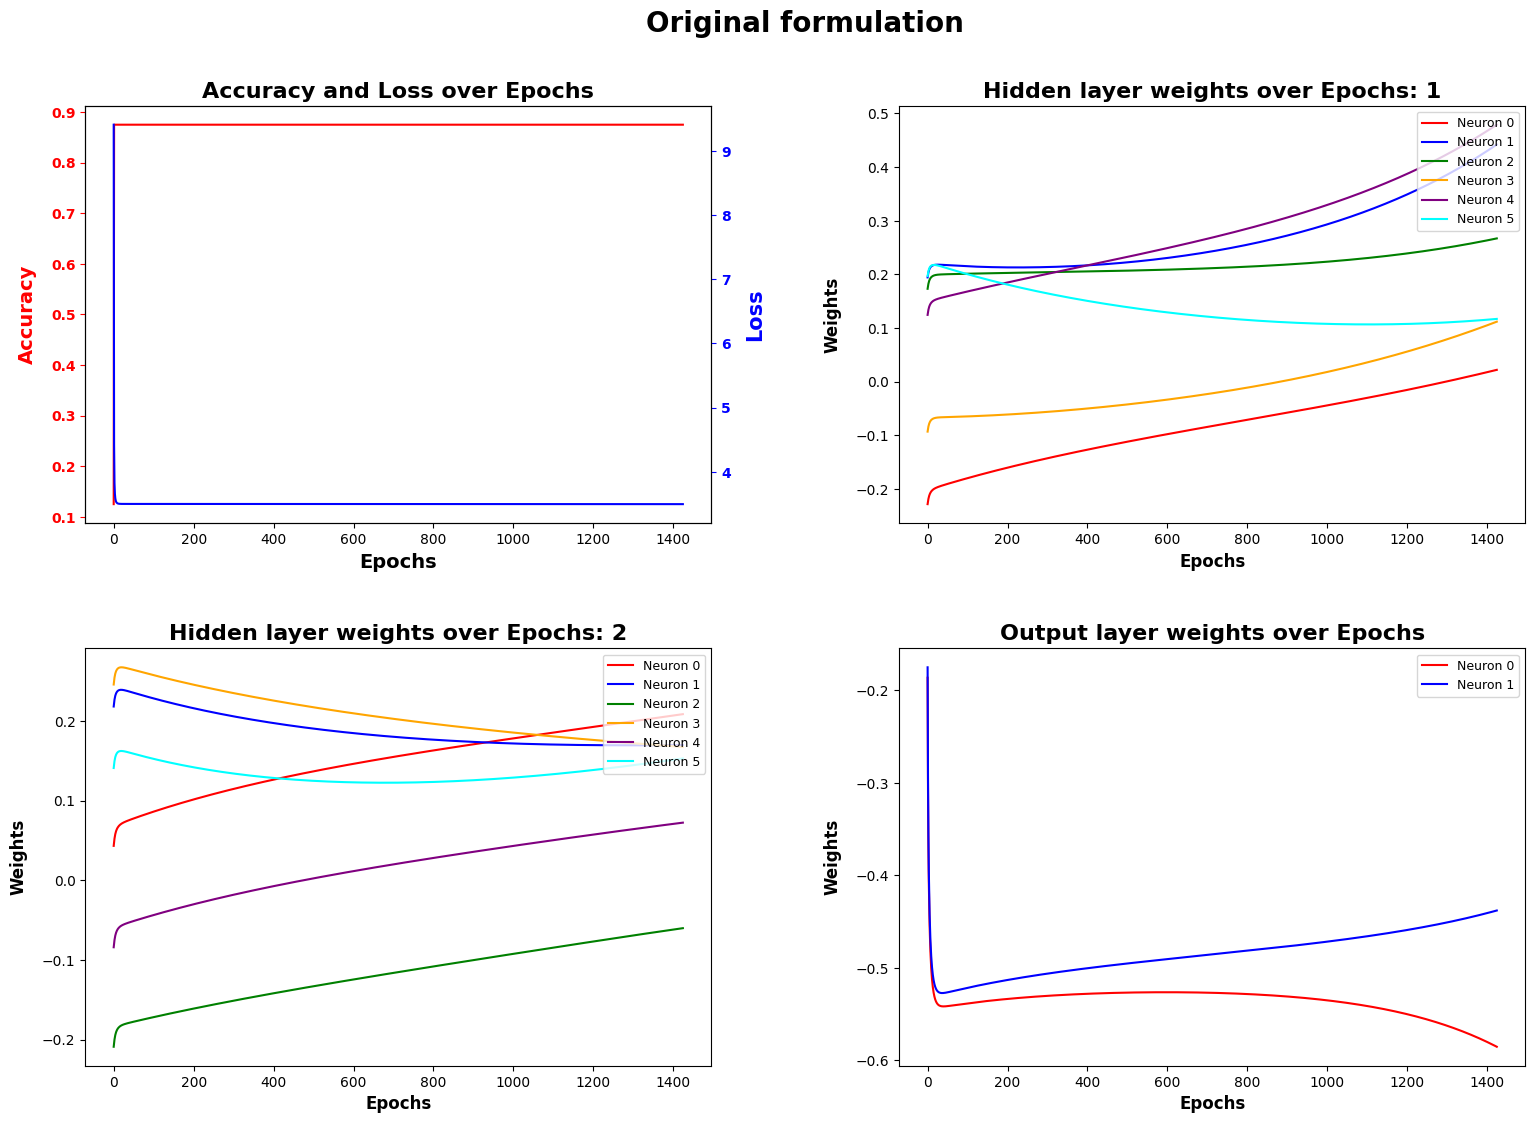

In [10]:
model_00: paper_net = paper_net()
h_lay_00: Tensor = torch.zeros(N_HEPOCHS, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_00: Tensor = torch.zeros(N_HEPOCHS, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_00: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)
loss_00: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)

train_net(model_00, train_tdl, h_lay_00, o_lay_00, acc_00, loss_00)
plot_all(h_lay_00, o_lay_00, acc_00, loss_00, "Original formulation")

Even if the accuracy reached seems to be very impressive, this is due to the fact the dataset is very unbalanced, and the most at the end this is the performance of a dummy classifier which always predicts that the number is not palindromic. 

#### 2.2 Balanced dataset

Use the same network but with the `balanced dataset`:

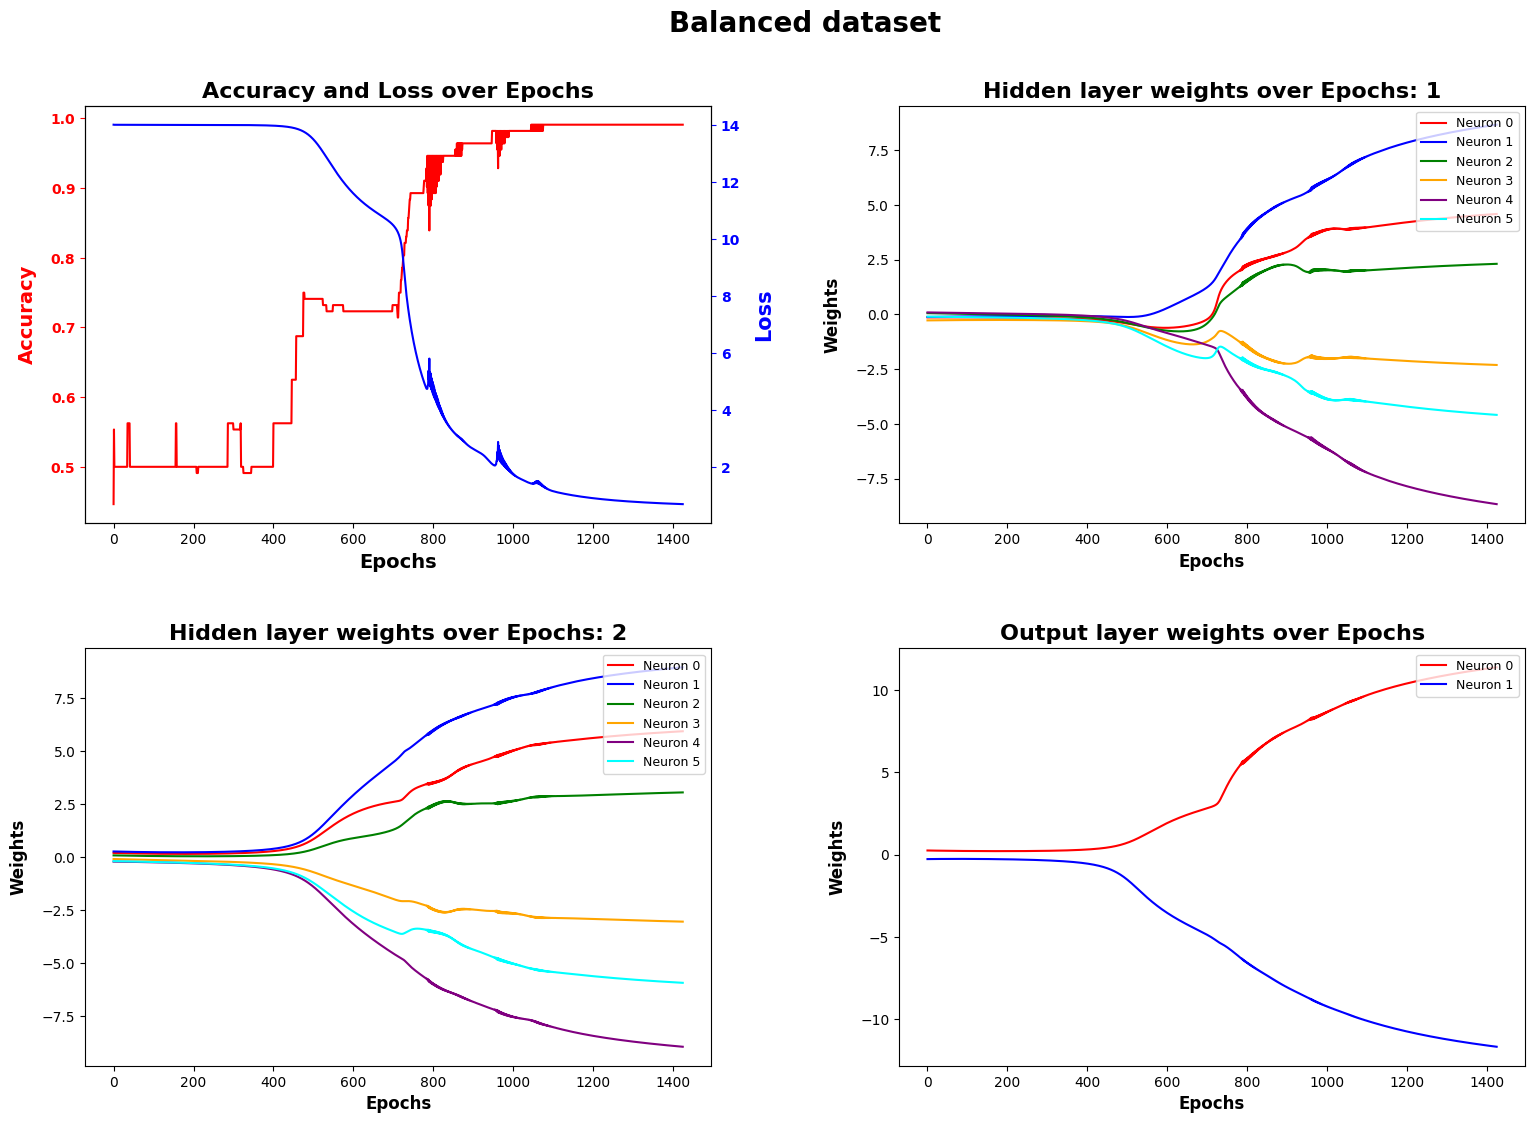

In [11]:
model_01: paper_net = paper_net()
h_lay_01: Tensor = torch.zeros(N_HEPOCHS, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_01: Tensor = torch.zeros(N_HEPOCHS, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_01: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)
loss_01: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)

train_net(model_01, train_balanced_tdl, h_lay_01, o_lay_01, acc_01, loss_01)
plot_all(h_lay_01, o_lay_01, acc_01, loss_01, "Balanced dataset")

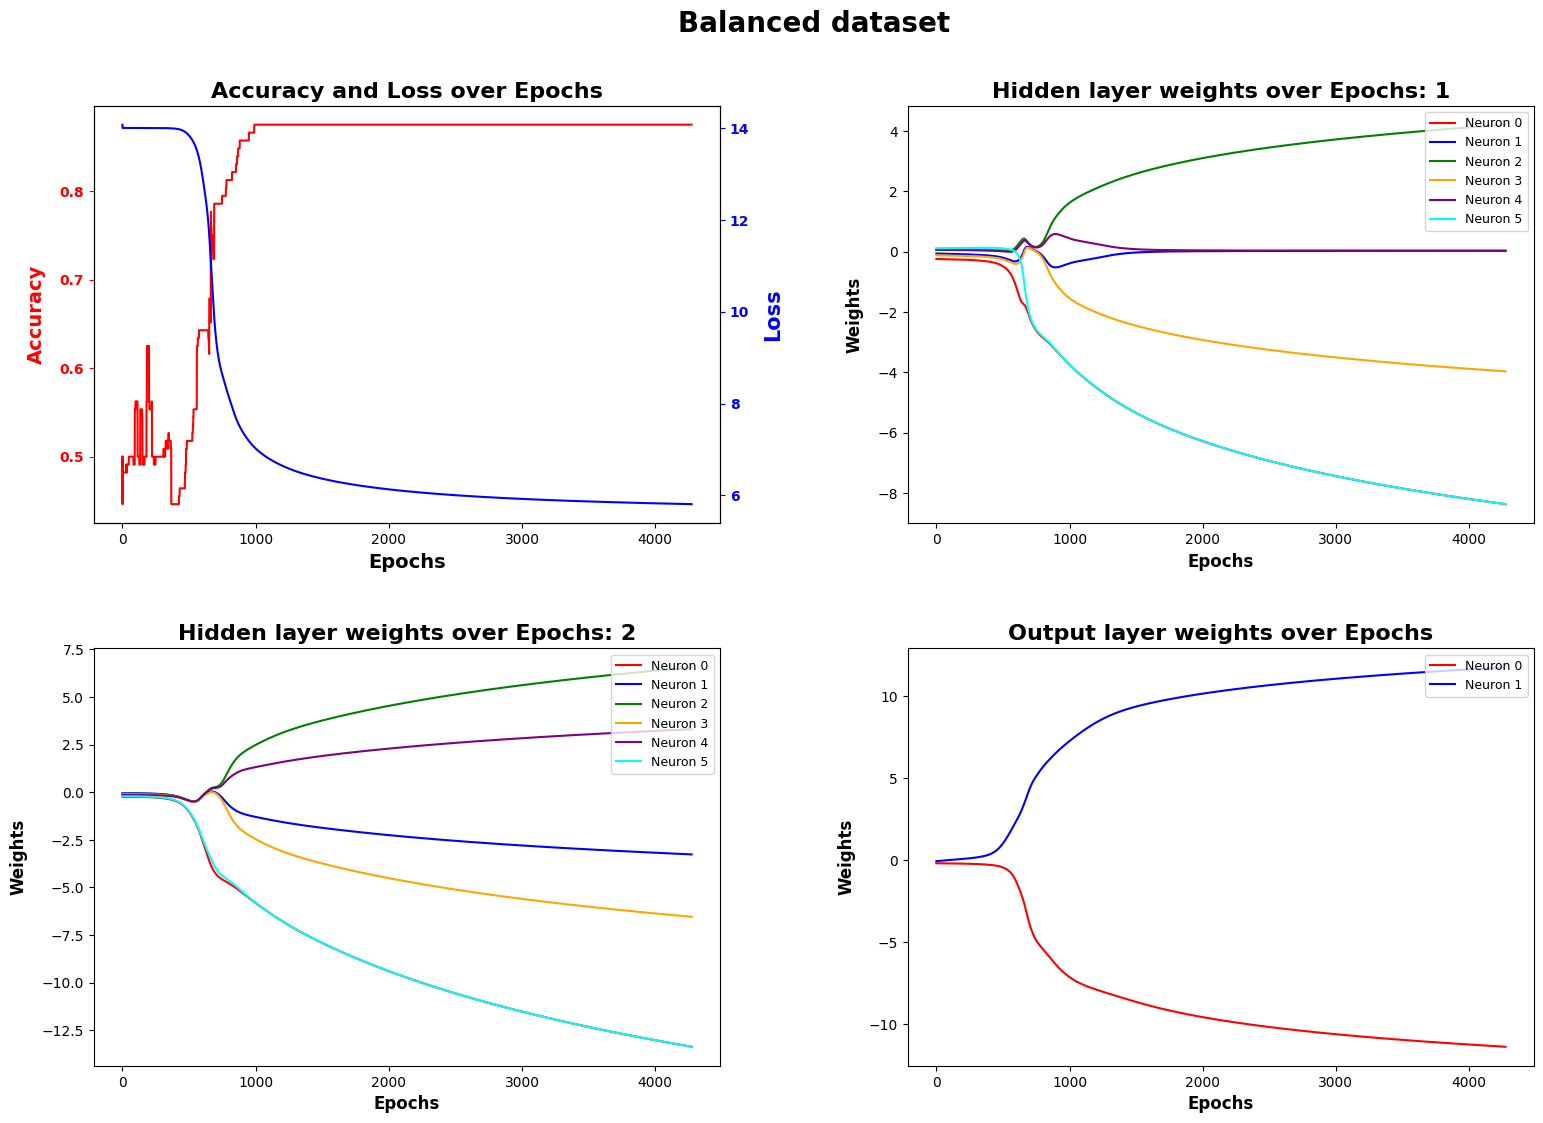

In [12]:
# Let's train a little more because it seems that it begin to converge to 1 at about 1200 epochs
model_01_bis = paper_net()
custom_n_epochs: int = N_HEPOCHS*3

h_lay_01_bis: Tensor = torch.zeros(custom_n_epochs, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_01_bis: Tensor = torch.zeros(custom_n_epochs, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_01_bis: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)
loss_01_bis: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)

train_net(model_01_bis, train_balanced_tdl, h_lay_01_bis, o_lay_01_bis, acc_01_bis, loss_01_bis, n_epochs=custom_n_epochs)
plot_all(h_lay_01_bis, o_lay_01_bis, acc_01_bis, loss_01_bis, "Balanced dataset", "plt-01-bis.png")

We can see that making the data balanced, help the network to learn how to proper do it's task, leading to an accuracy very close to 100%

#### 2.3 Varying the Learning Rate

Let's see how the network behaves when we change the learning rate. For this (and all the following) experiments, we will use the balanced dataset.

Let's try bot to double and to halve the learning rate:

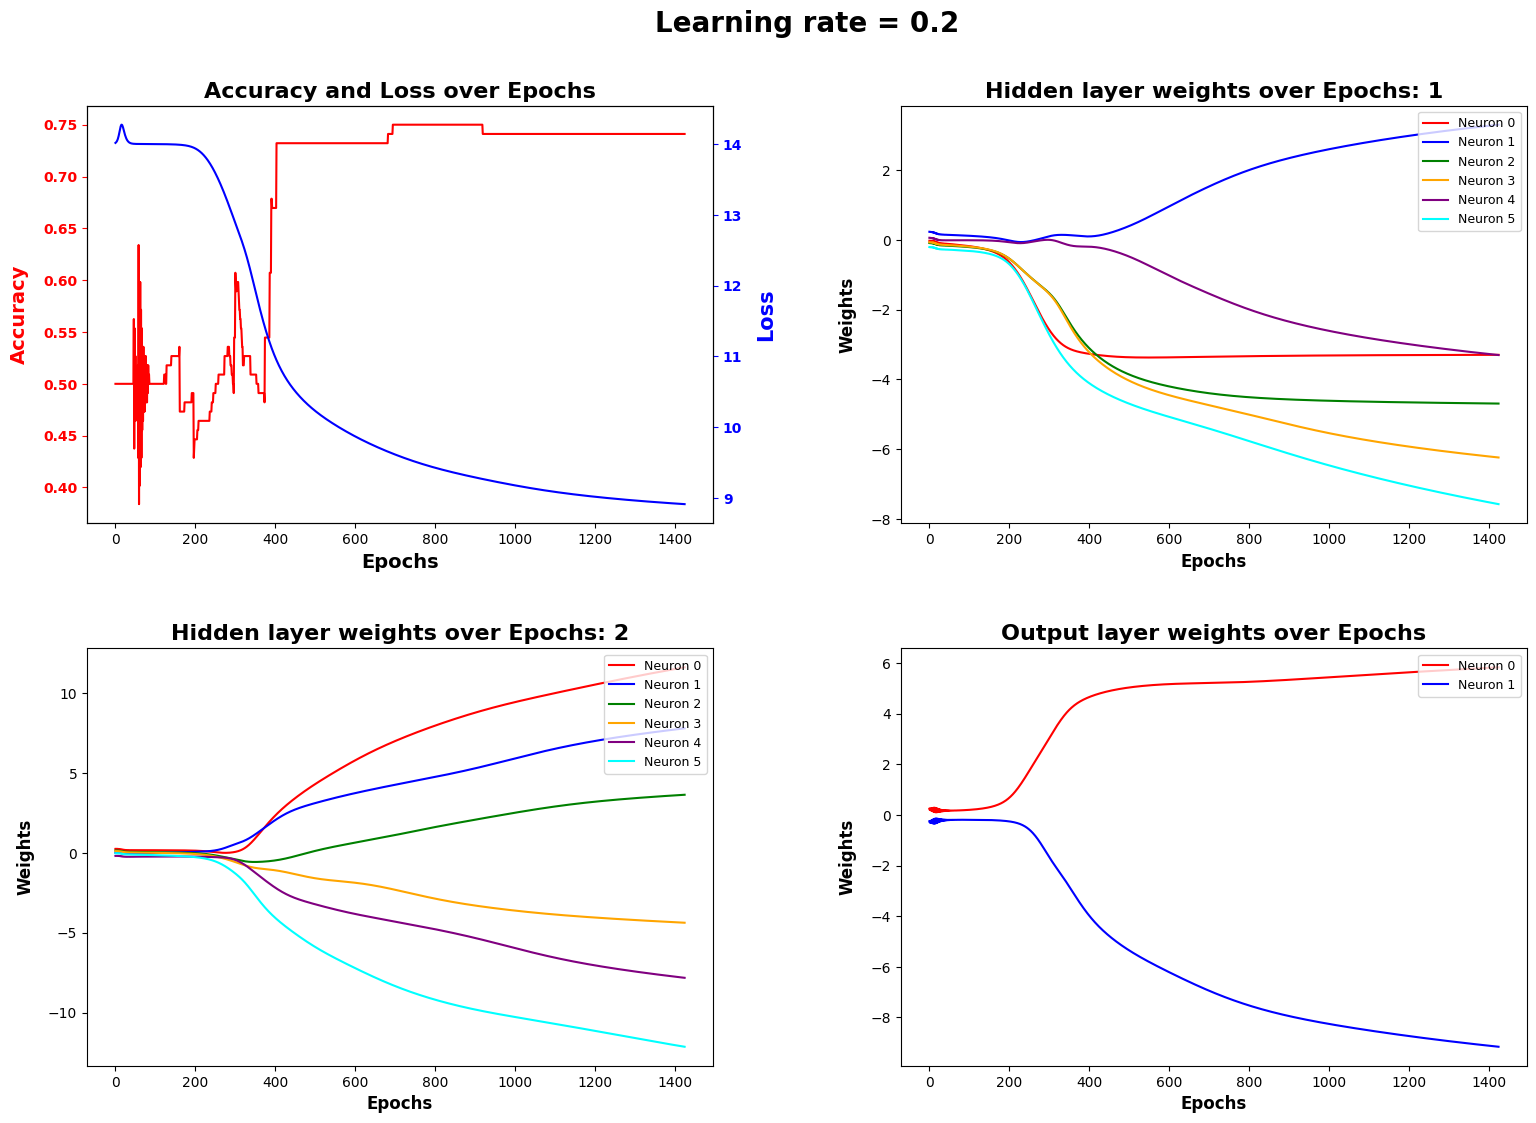

In [13]:
model_02 = paper_net()
h_lay_02: Tensor = torch.zeros(N_HEPOCHS, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_02: Tensor = torch.zeros(N_HEPOCHS, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_02: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)
loss_02: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)

custom_lr = 0.2
train_net(model_02, train_balanced_tdl, h_lay_02, o_lay_02, acc_02, loss_02, lr=custom_lr)
plot_all(h_lay_02, o_lay_02, acc_02, loss_02, f"Learning rate = {custom_lr}")

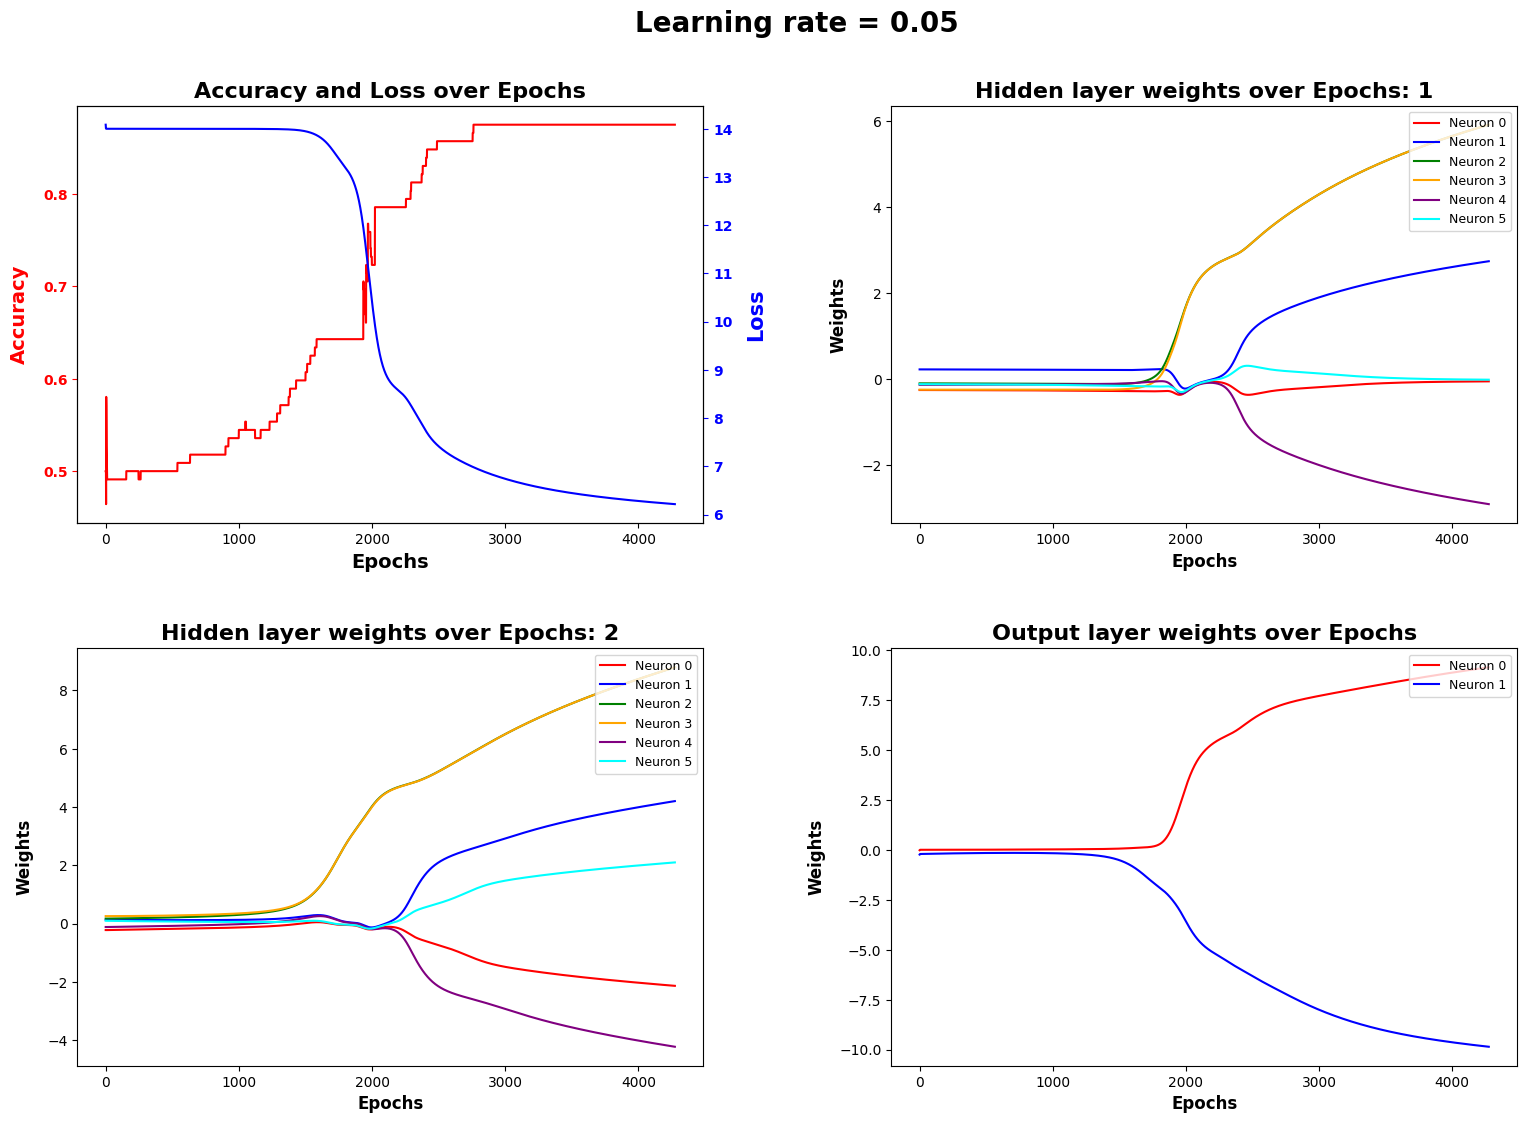

In [14]:
model_02_bis = paper_net()
custom_n_epochs: int = N_HEPOCHS*3
h_lay_02_bis: Tensor = torch.zeros(custom_n_epochs, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_02_bis: Tensor = torch.zeros(custom_n_epochs, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_02_bis: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)
loss_02_bis: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)

custom_lr = 0.05
train_net(model_02_bis, train_balanced_tdl, h_lay_02_bis, o_lay_02_bis, acc_02_bis, loss_02_bis, lr=custom_lr, n_epochs=custom_n_epochs)
plot_all(h_lay_02_bis, o_lay_02_bis, acc_02_bis, loss_02_bis, f"Learning rate = {custom_lr}")

We can see that increasing the learning rate leads to a faster convergence, even if in the meanwhile the loss function is more oscillating. On the other hand, decreasing the learning rate leads to a slower convergence, but the loss function is more stable.

#### 2.4 Varying the number of hidden neurons

Let's come back to the original sigmoid activation function and see how the network behaves when we change the number of hidden neurons. I will try to use 4 neurons in the hidden layer.

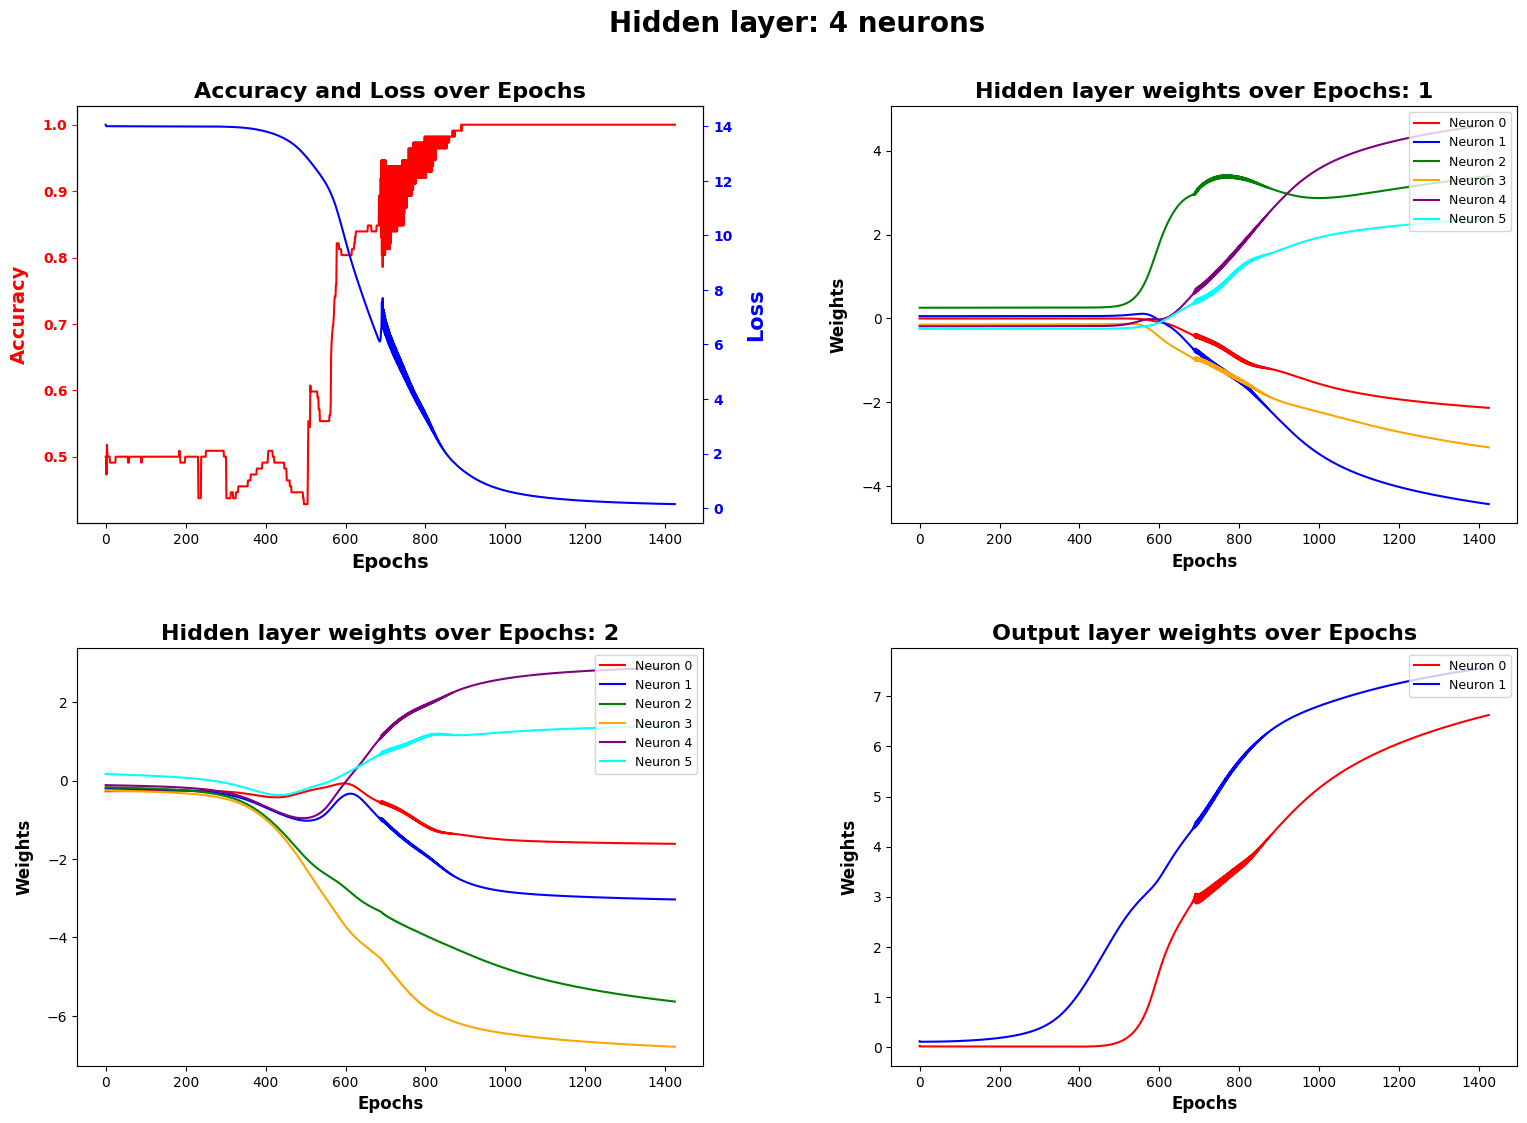

In [15]:
custom_h_layers = 4

model_03 = paper_net(hidden_size=custom_h_layers)
h_lay_03: Tensor = torch.zeros(N_HEPOCHS, custom_h_layers, N_DIGITS, dtype=STD_DTYPE)    
o_lay_03: Tensor = torch.zeros(N_HEPOCHS, 1, custom_h_layers, dtype=STD_DTYPE)
acc_03: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)
loss_03: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)

train_net(model_03, train_balanced_tdl, h_lay_03, o_lay_03, acc_03, loss_03, lr=0.1)
plot_all(h_lay_03, o_lay_03, acc_03, loss_03, f"Hidden layer: {custom_h_layers} neurons")

The convergence of the accuracy to one is faster. 

#### 2.5 Varying the loss function

Let's se what happens if we use the [SoftMarginLoss](https://pytorch.org/docs/stable/generated/torch.nn.SoftMarginLoss.html) instead of the custom. I have chosen that one because [here](https://pytorch.org/docs/stable/nn.html#loss-functions) it's reported that it is used for binary classification problems.

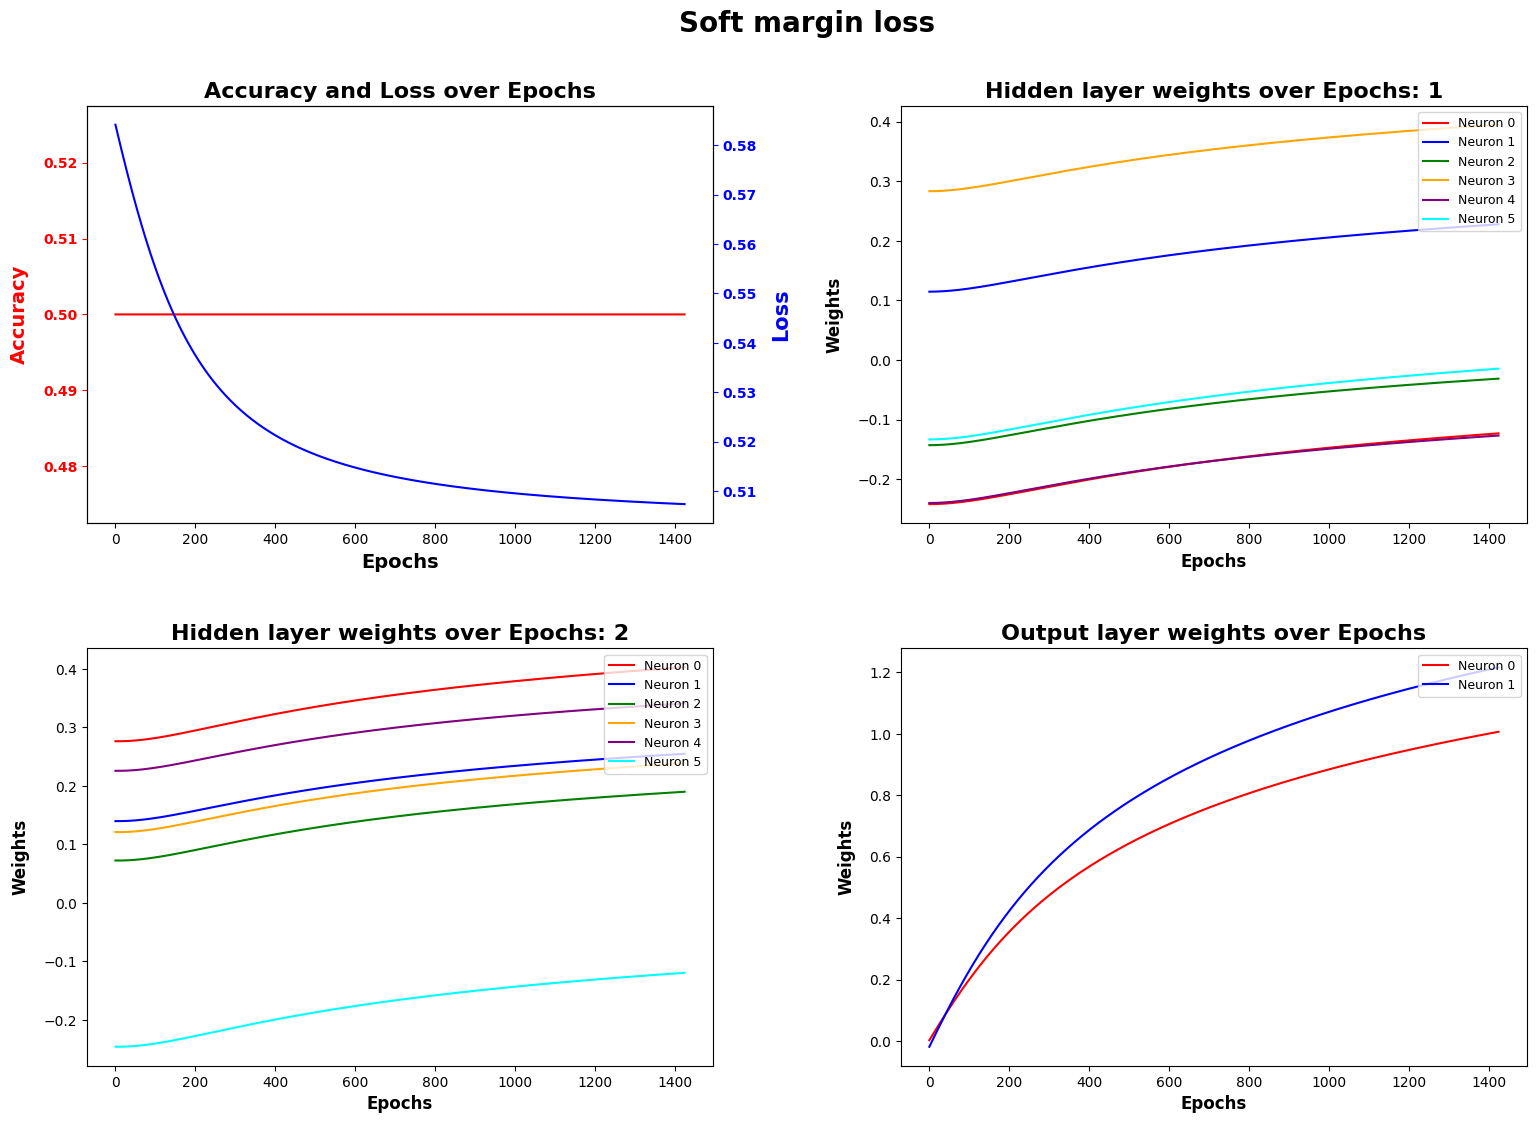

In [16]:
model_04 = paper_net()
h_lay_04: Tensor = torch.zeros(N_HEPOCHS, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_04: Tensor = torch.zeros(N_HEPOCHS, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_04: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)
loss_04: Tensor = torch.zeros(N_HEPOCHS, dtype=STD_DTYPE)

train_net(model_04, train_balanced_tdl, h_lay_04, o_lay_04, acc_04, loss_04, loss_function=torch.nn.SoftMarginLoss())
plot_all(h_lay_04, o_lay_04, acc_04, loss_04, "Soft margin loss")

This appears immediately as a bad choice. Even if the loss function is decreasing, the accuracy is converging to 0.5, like it is a random classifier.

#### 2.6 Varying the activation function

Let's see how the network behaves when we change the activation function. I will use the [relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) function since it is one of the most used in the literature nowadays.
The different activation function is just for the hidden layer. The output layer will still use the sigmoid function, this is because the output of the network should be in the range [0, 1].

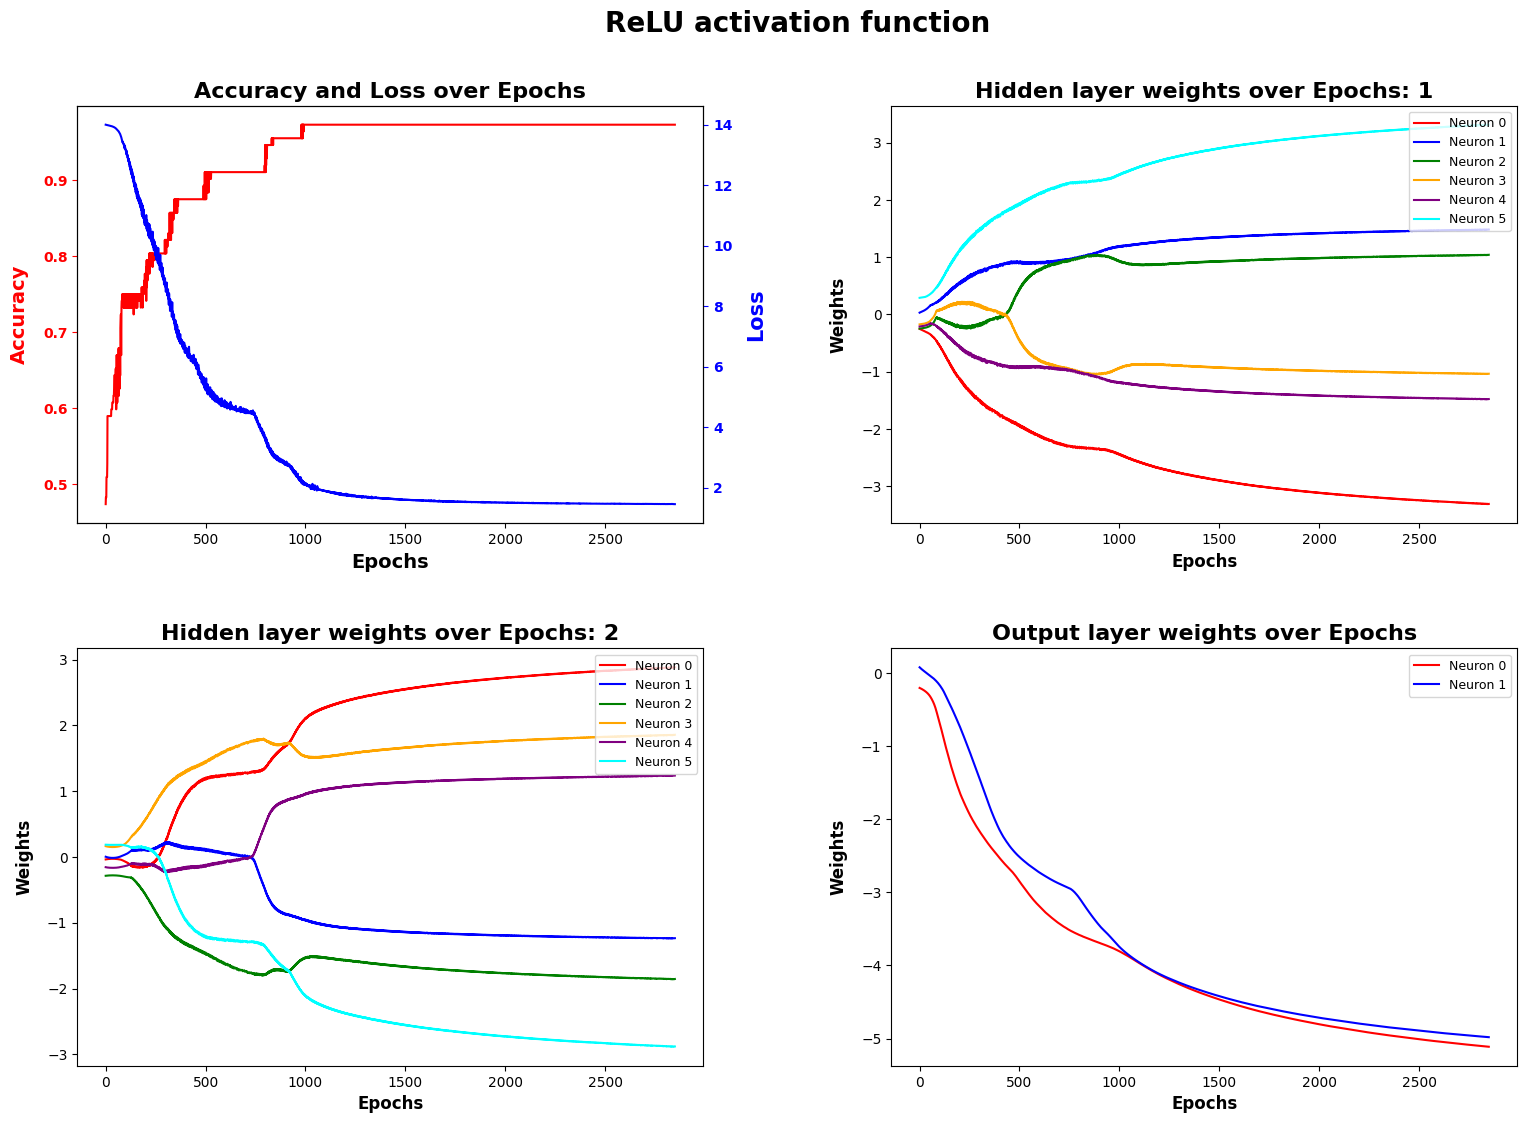

In [17]:
model_05 = paper_net(func=torch.nn.ReLU())
custom_n_epochs = N_HEPOCHS*2
h_lay_05: Tensor = torch.zeros(custom_n_epochs, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_05: Tensor = torch.zeros(custom_n_epochs, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_05: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)
loss_05: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)

train_net(model_05, train_balanced_tdl, h_lay_05, o_lay_05, acc_05, loss_05, n_epochs=custom_n_epochs, lr=0.01)
plot_all(h_lay_05, o_lay_05, acc_05, loss_05, "ReLU activation function")

#### 2.7 Varying the optimizer

Instead of the SGD, let's try to use the [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimizer.

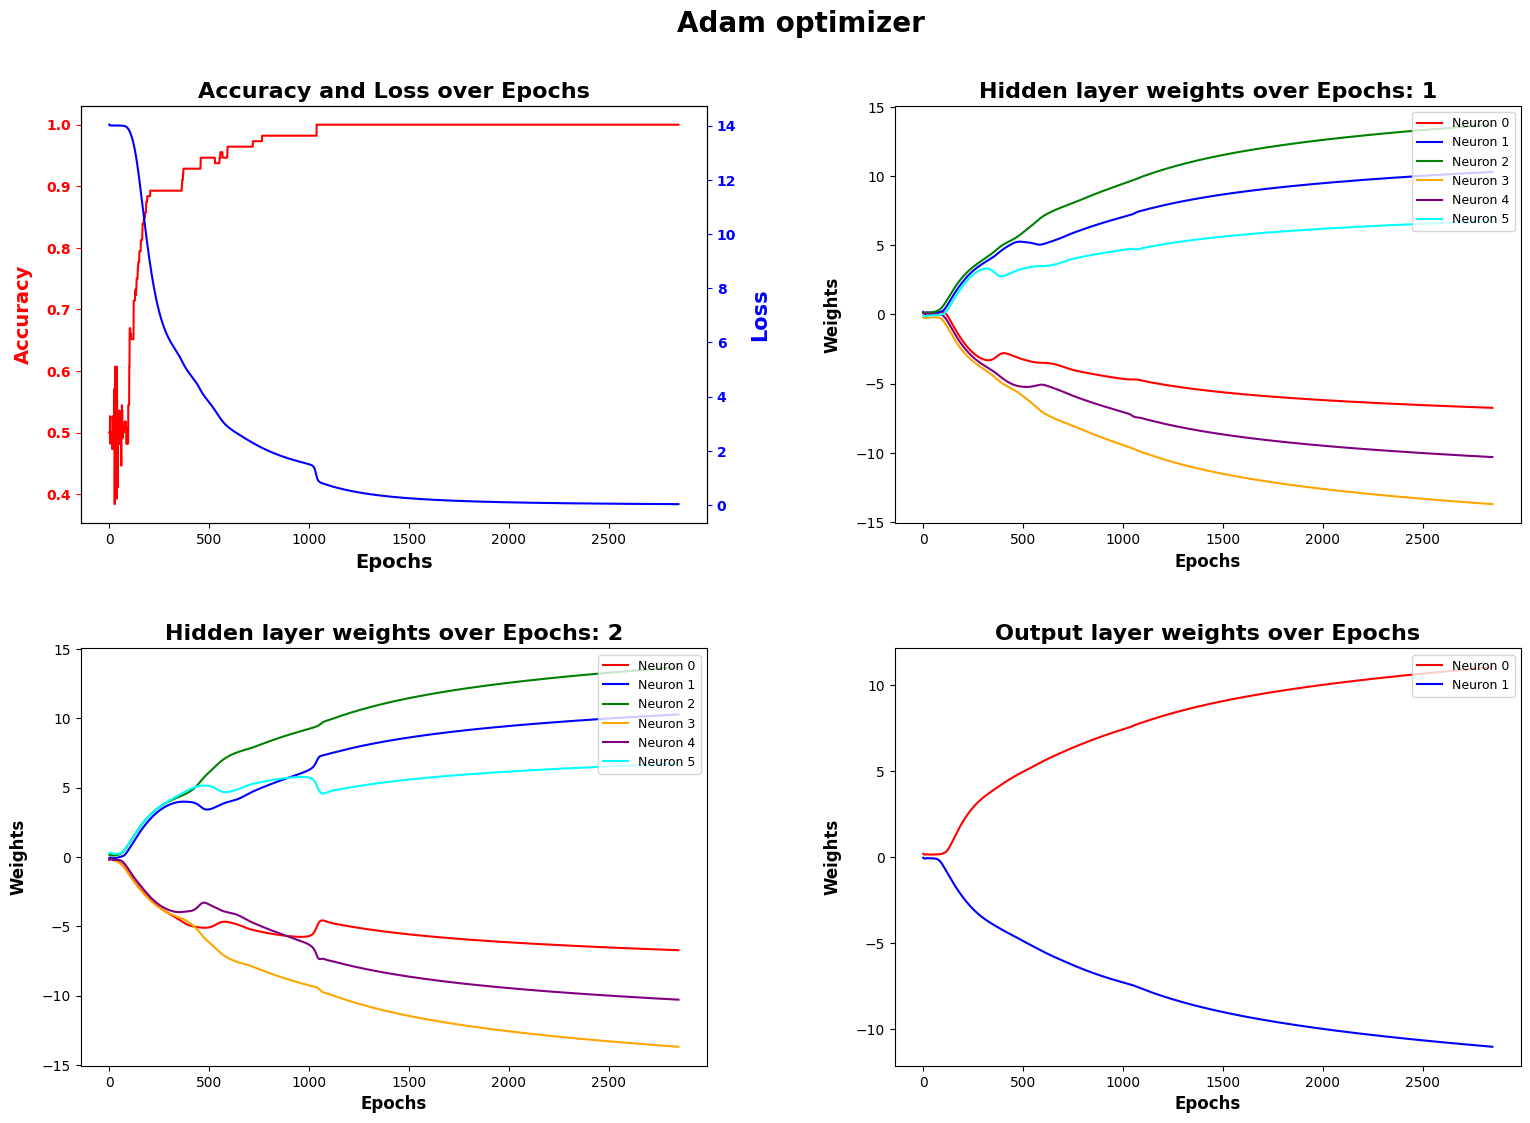

In [18]:
model_06 = paper_net()
custom_n_epochs = N_HEPOCHS*2
h_lay_06: Tensor = torch.zeros(custom_n_epochs, N_HIDDEN, N_DIGITS, dtype=STD_DTYPE)
o_lay_06: Tensor = torch.zeros(custom_n_epochs, 1, N_HIDDEN, dtype=STD_DTYPE)
acc_06: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)
loss_06: Tensor = torch.zeros(custom_n_epochs, dtype=STD_DTYPE)

train_net(model_06, train_balanced_tdl, h_lay_06, o_lay_06, acc_06, loss_06, n_epochs=custom_n_epochs, lr=0.01, optimizer_obj=torch.optim.Adam)
plot_all(h_lay_06, o_lay_06, acc_06, loss_06, "Adam optimizer")

---

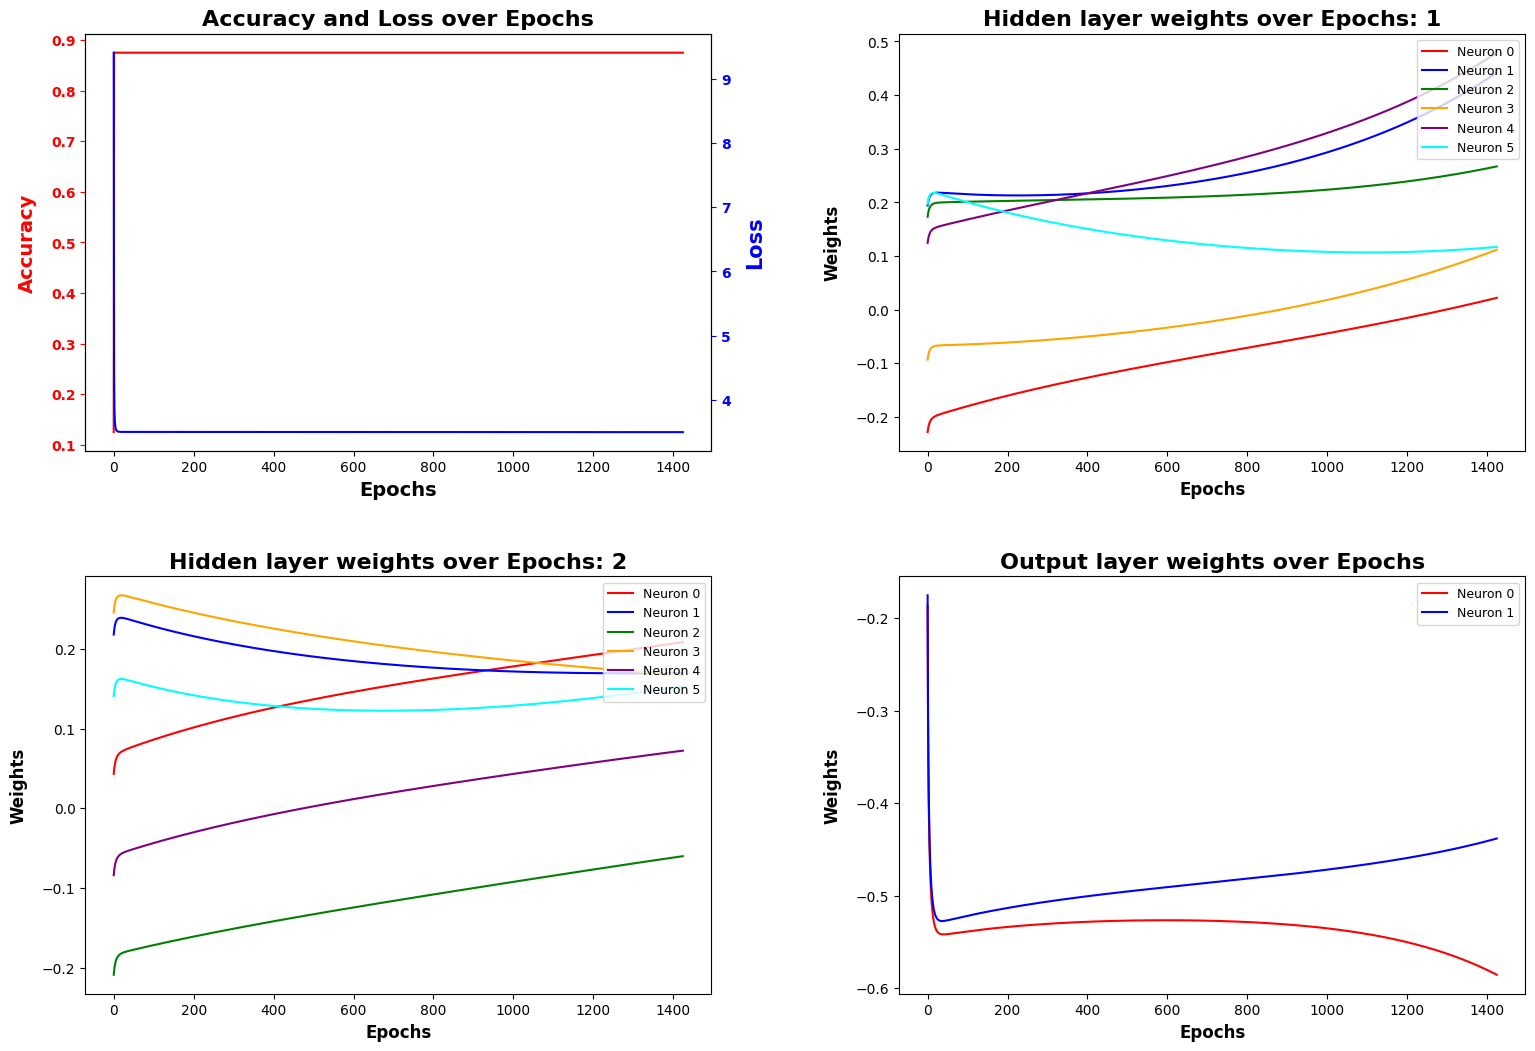

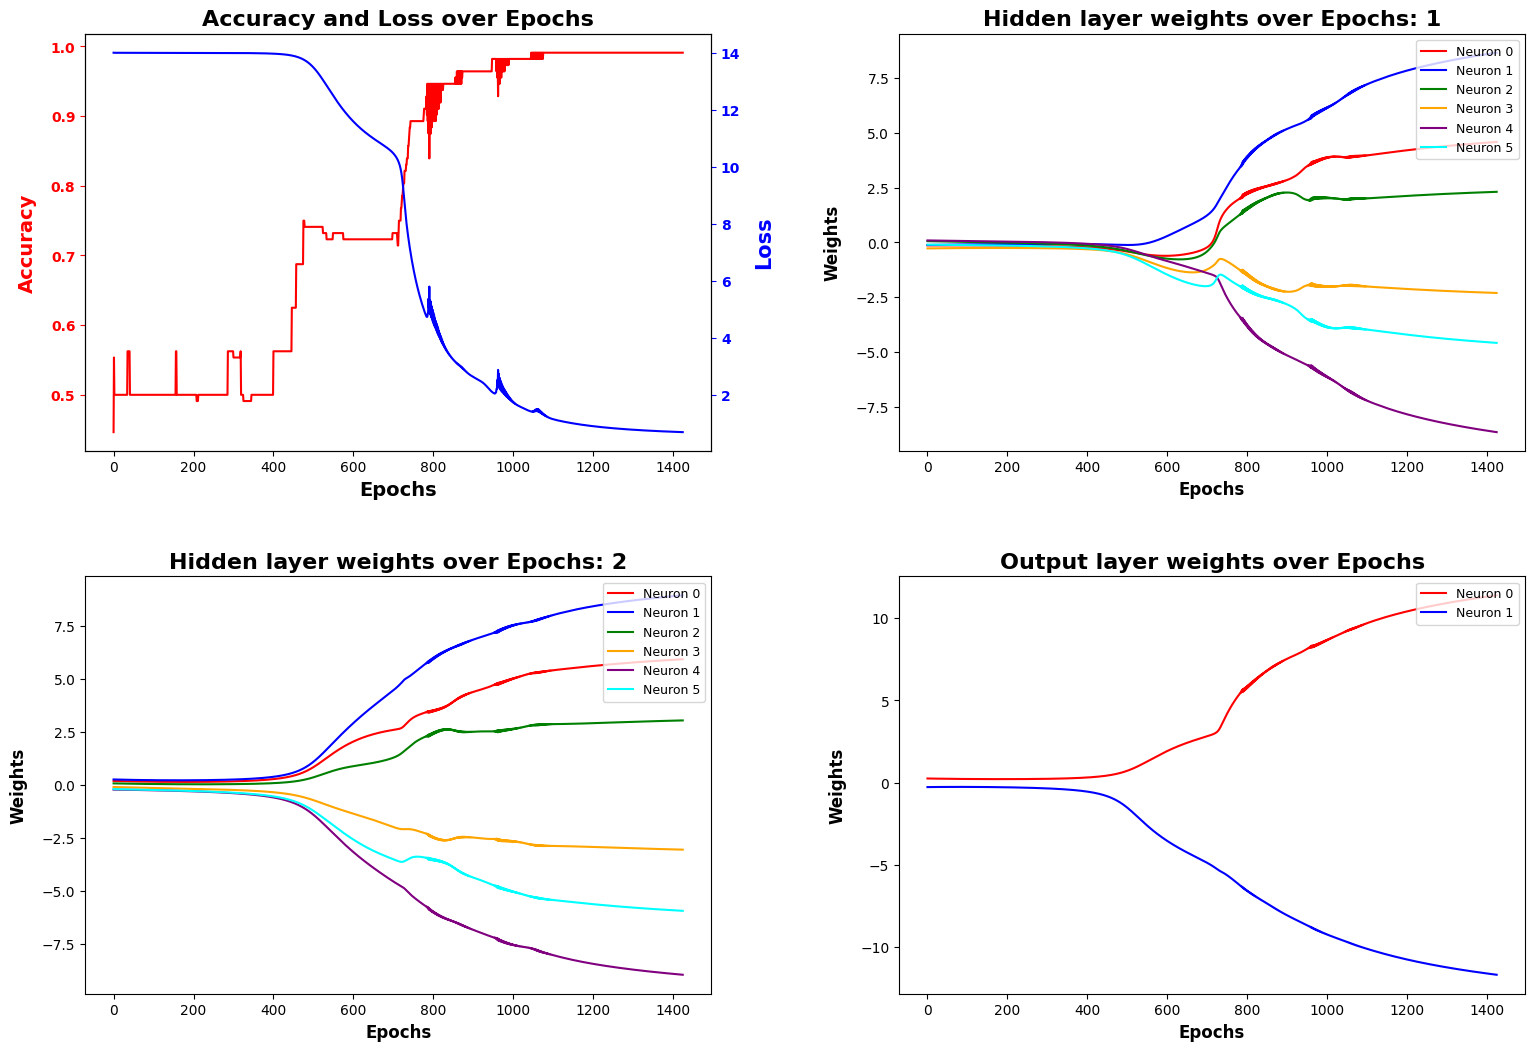

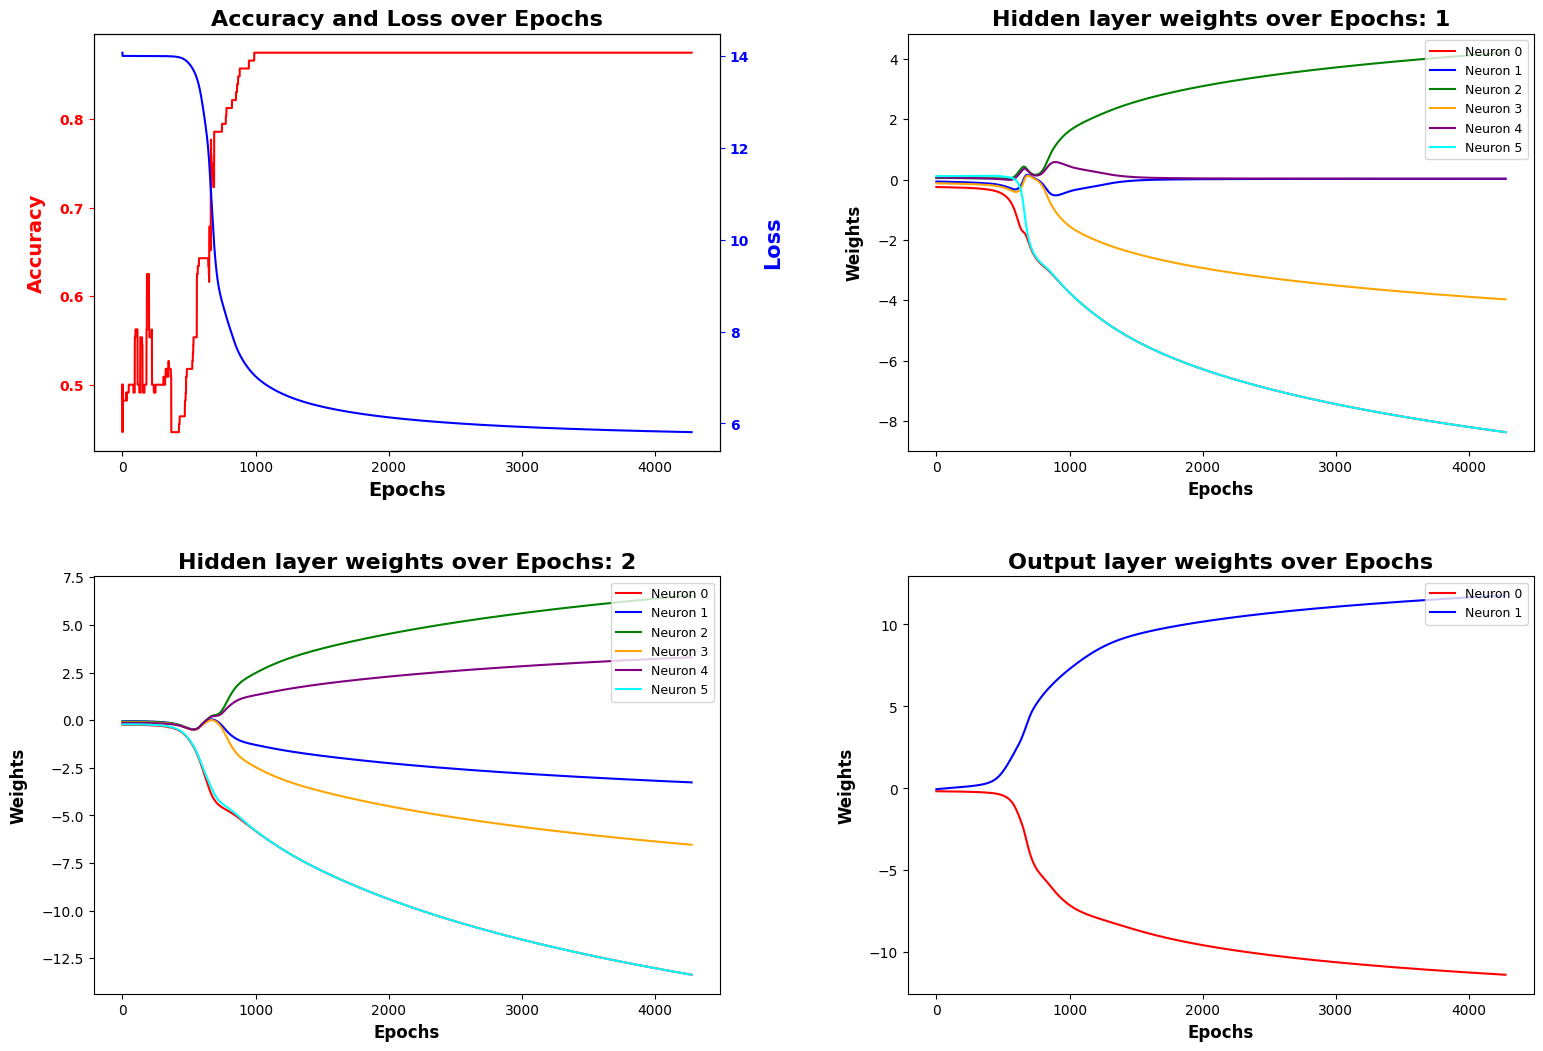

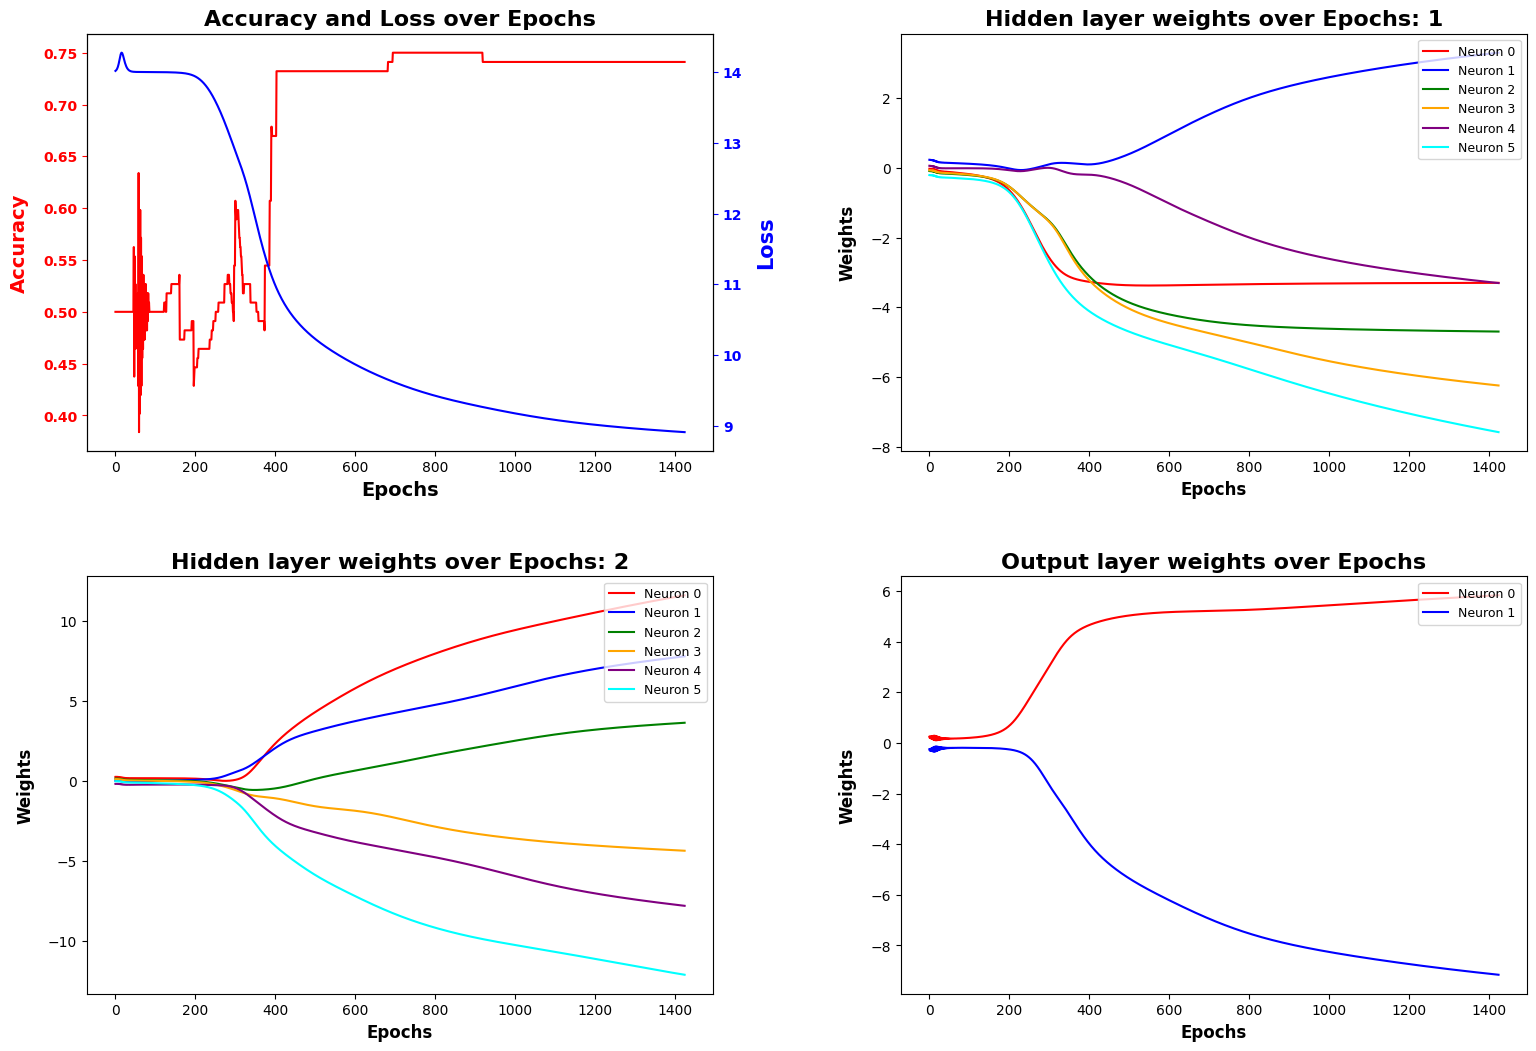

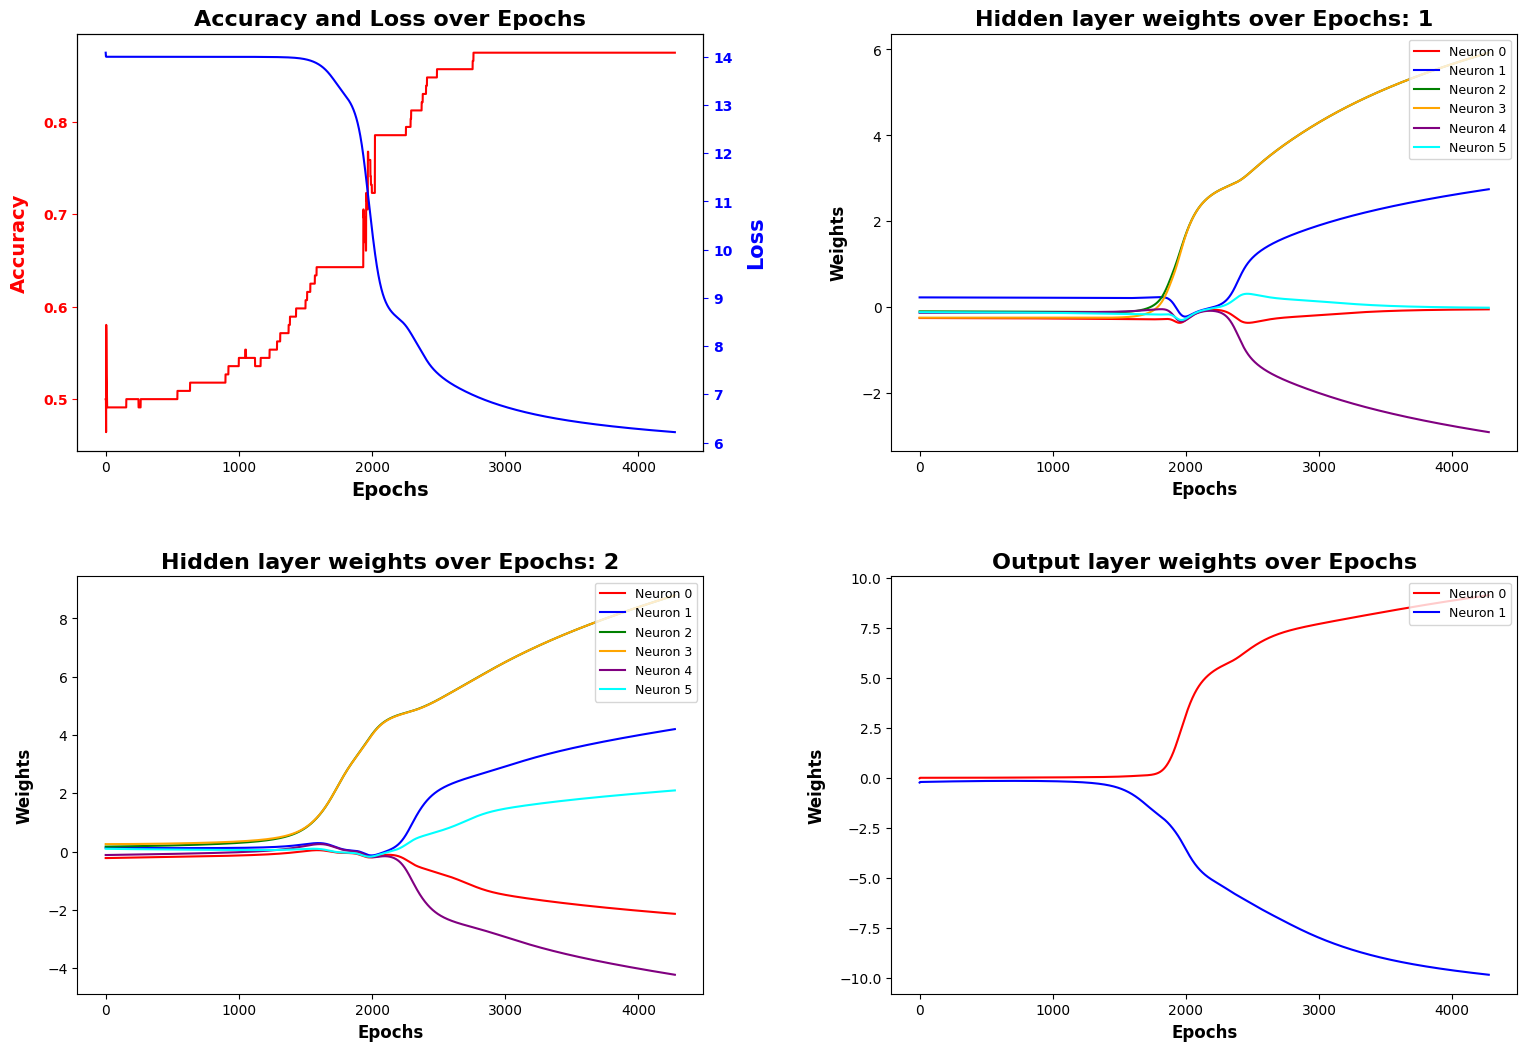

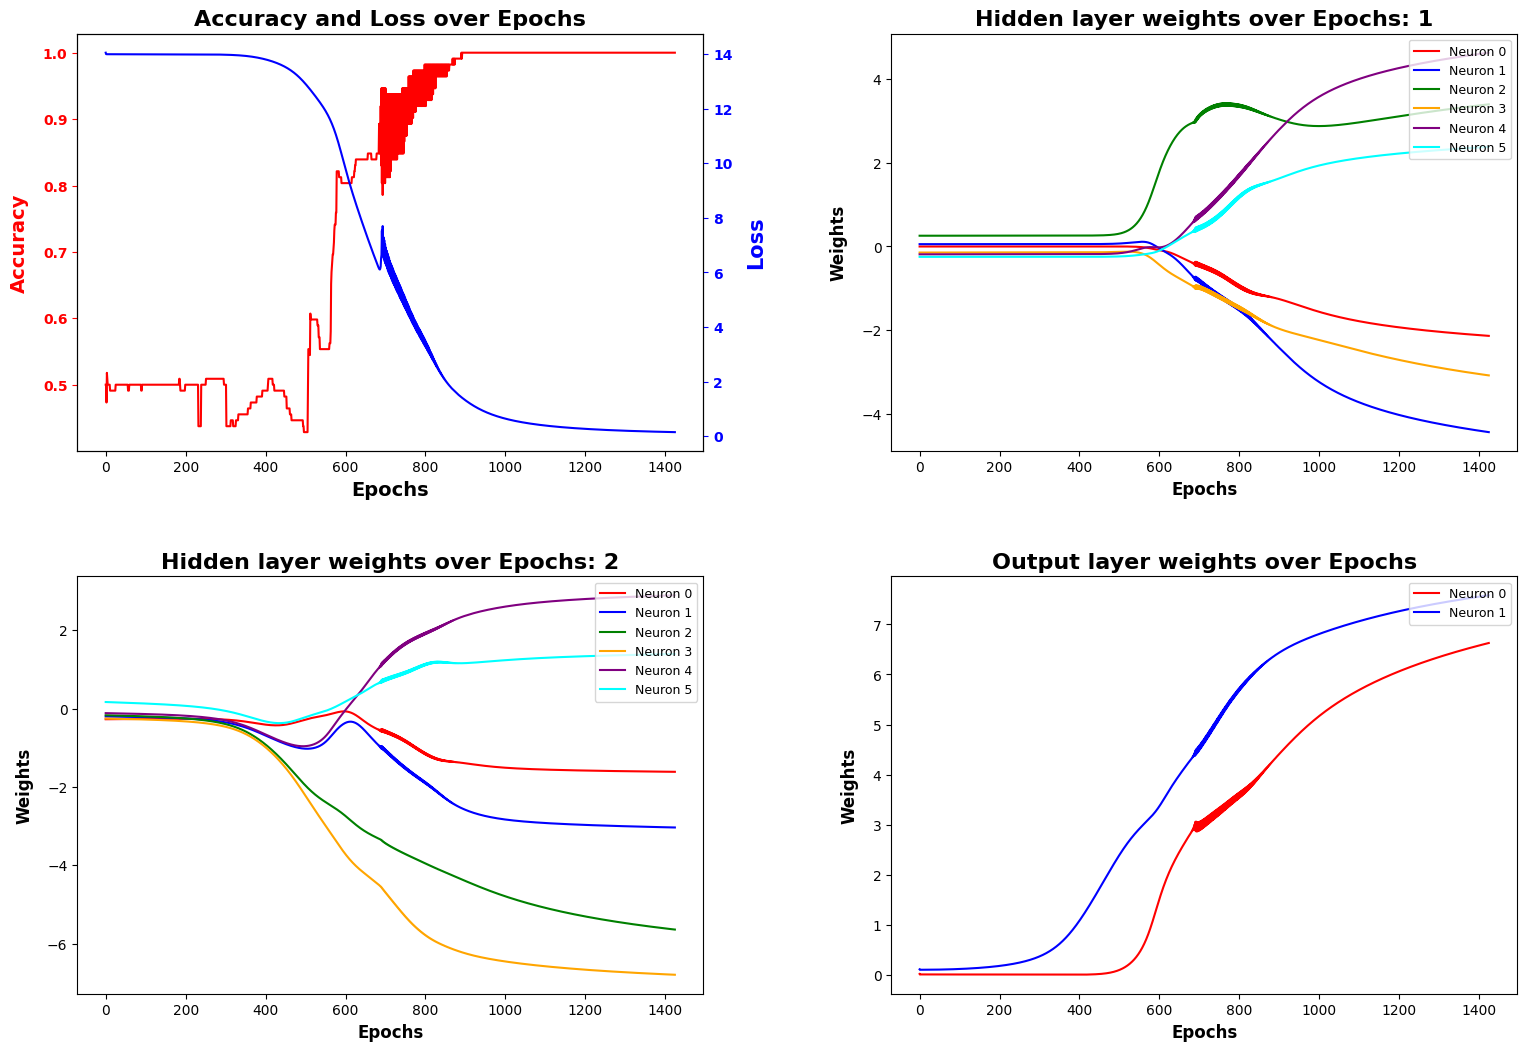

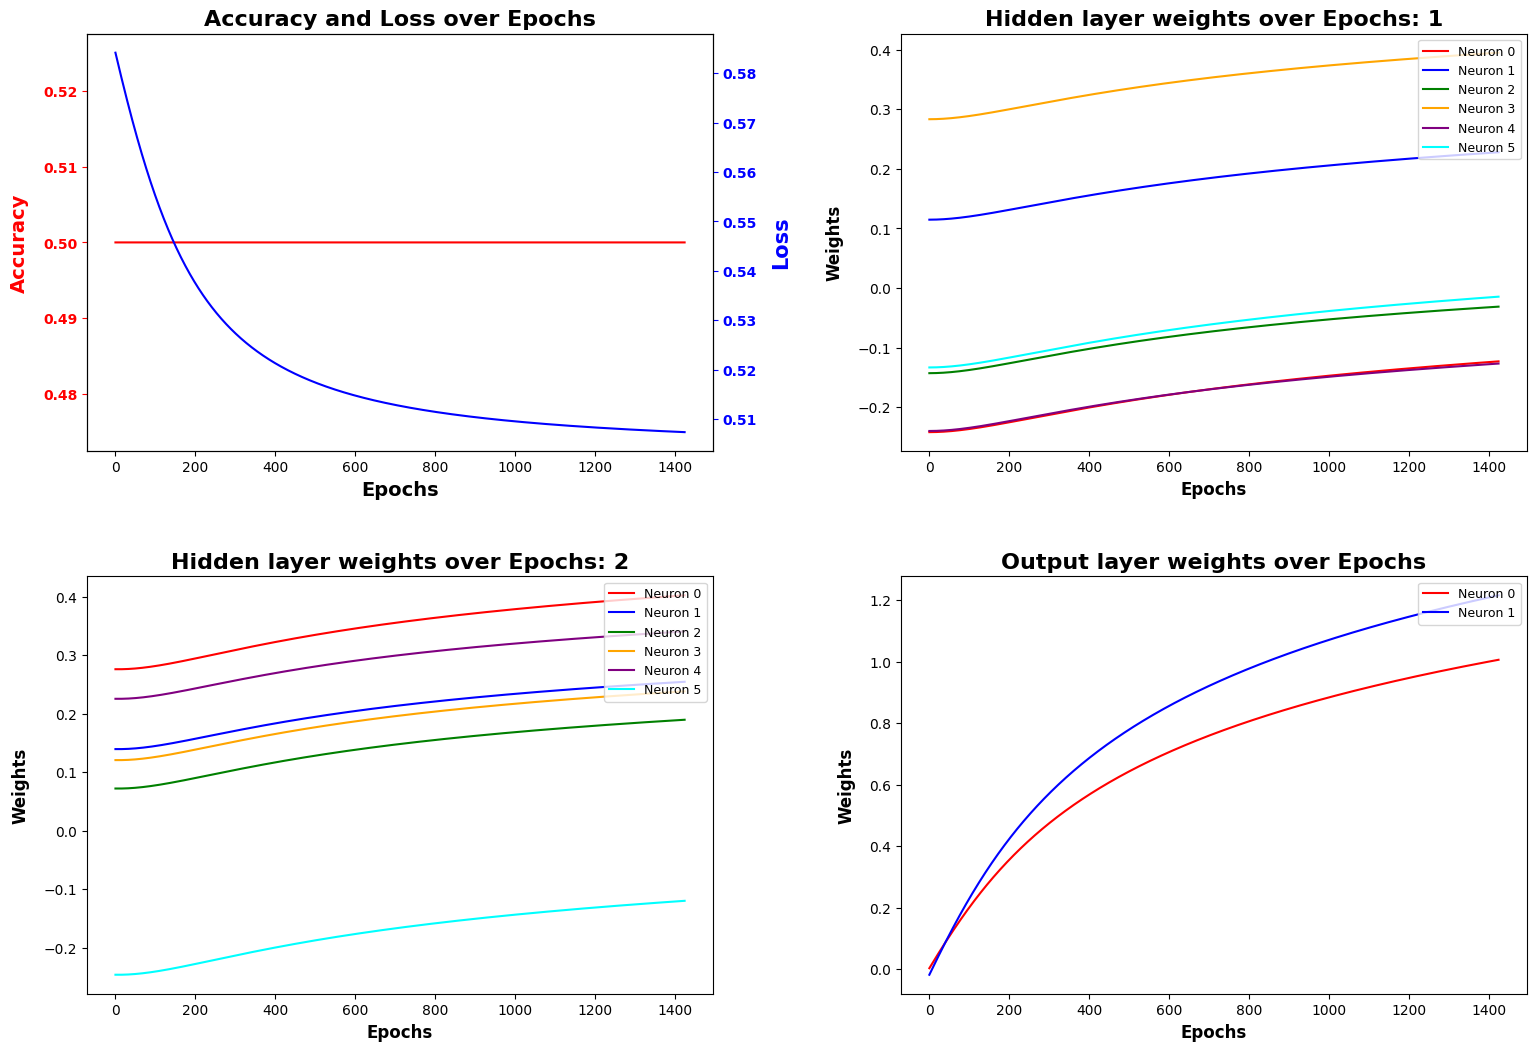

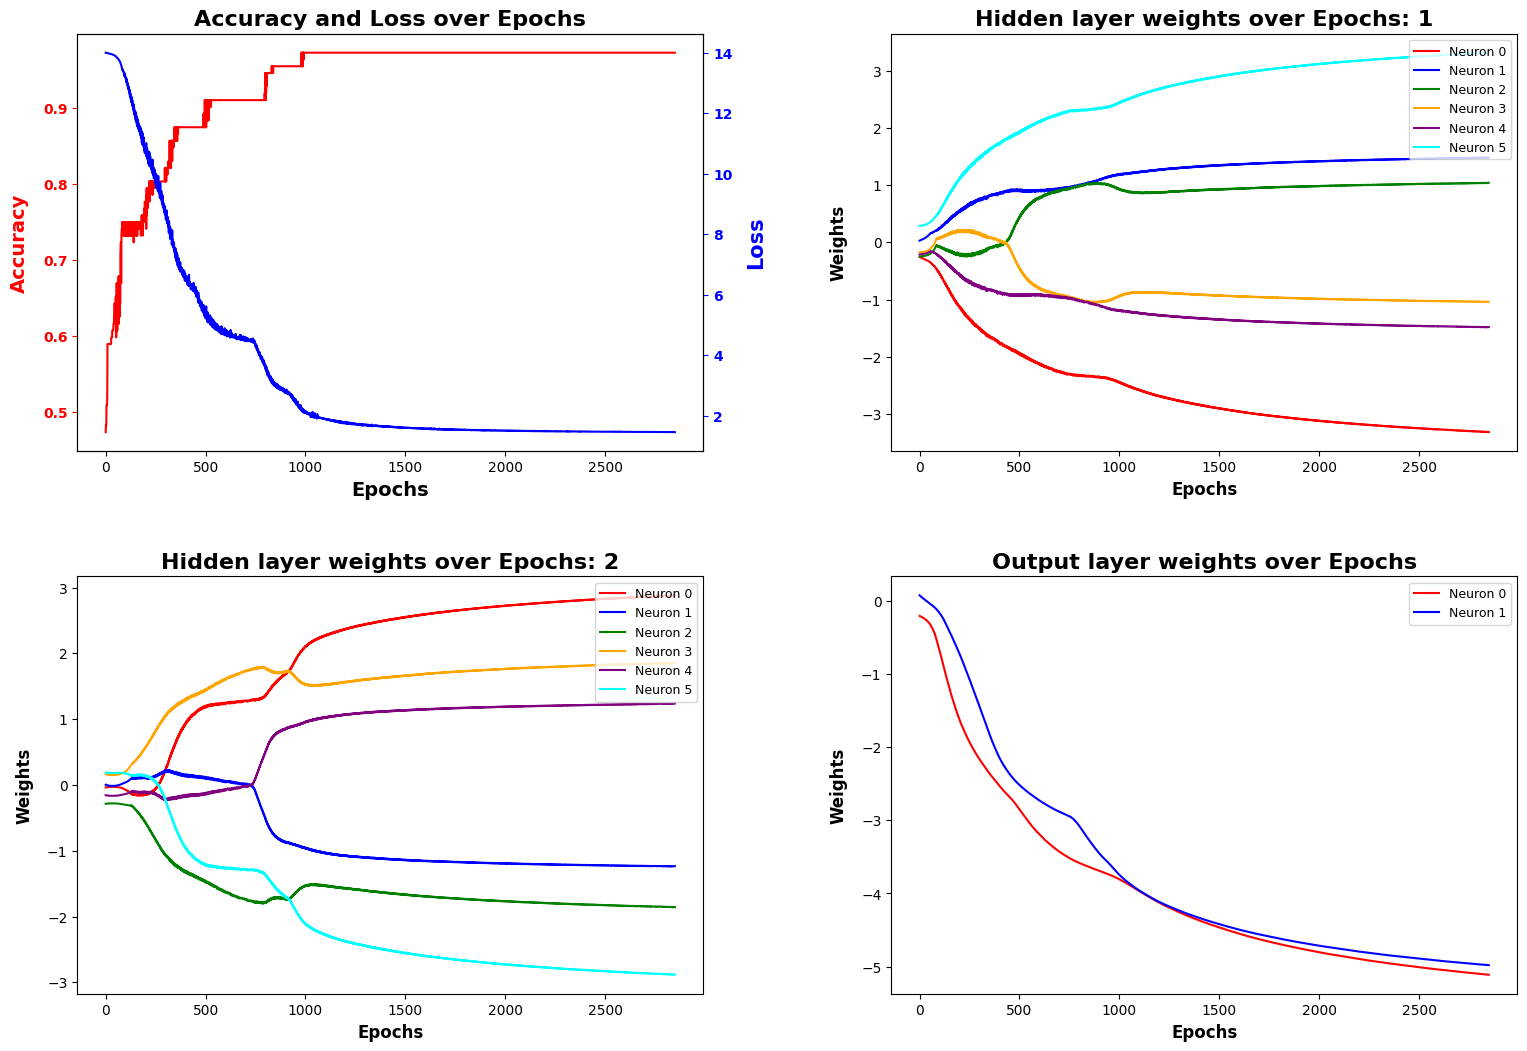

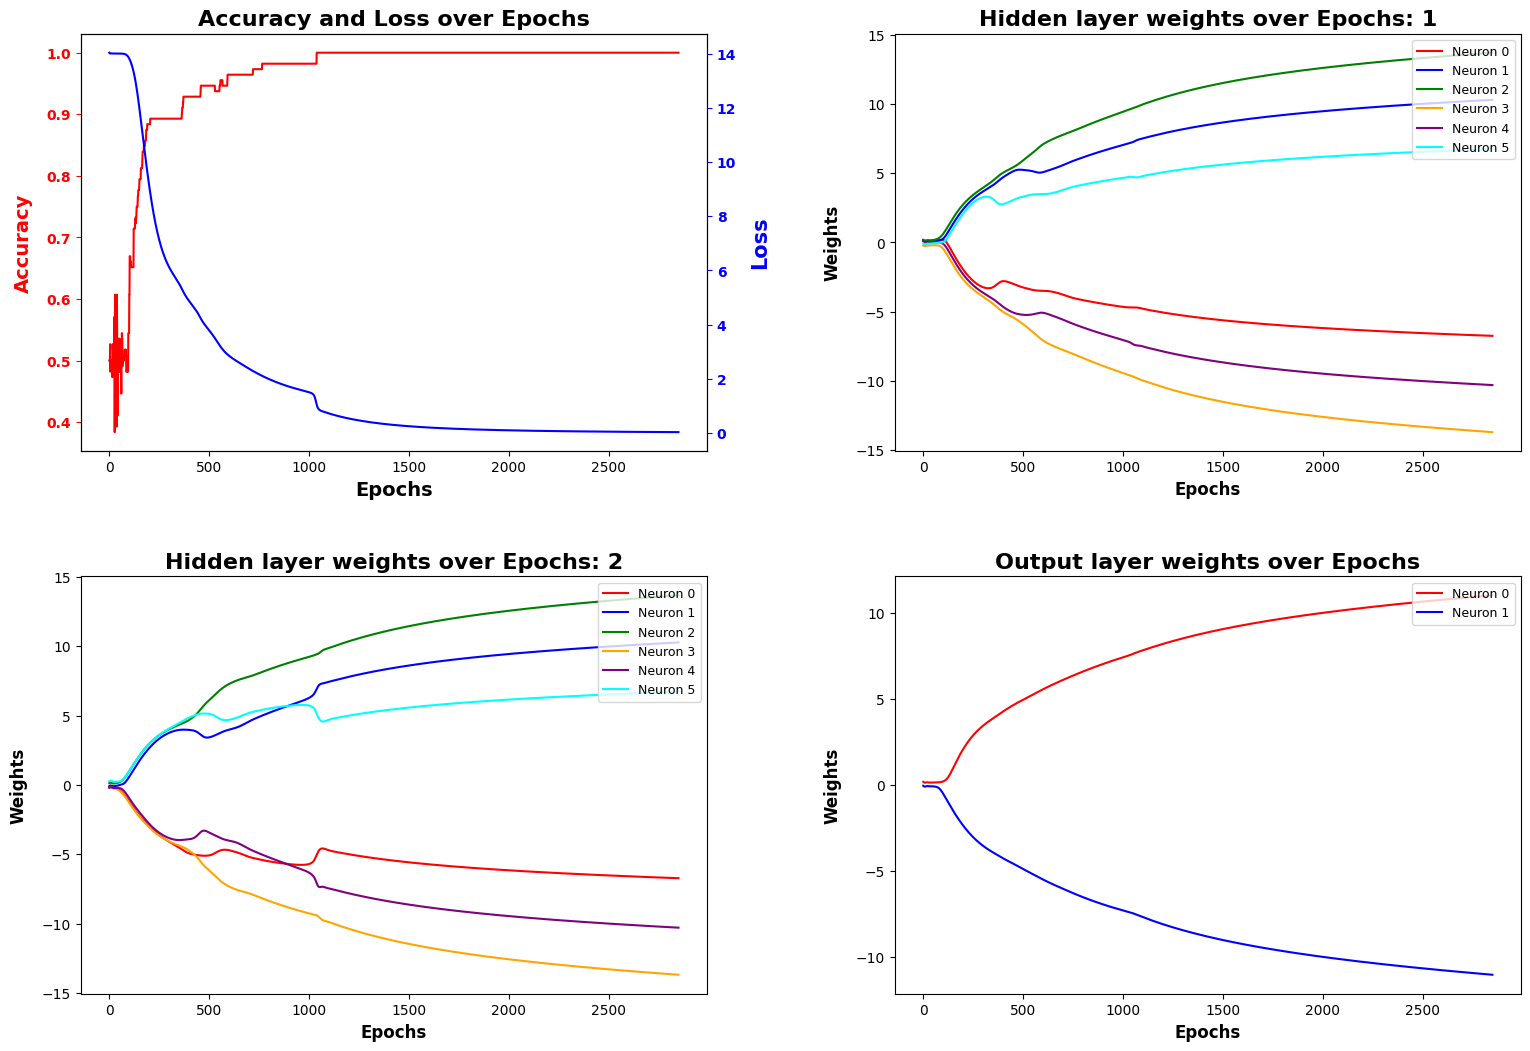

In [19]:
# Re-make the plot, without the title,  needed only for the report
plot_all(h_lay_00, o_lay_00, acc_00, loss_00, "", "plt-00.png")
plot_all(h_lay_01, o_lay_01, acc_01, loss_01, "", "plt-01.png")
plot_all(h_lay_01_bis, o_lay_01_bis, acc_01_bis, loss_01_bis, "", "plt-01-bis.png")
plot_all(h_lay_02, o_lay_02, acc_02, loss_02, "", "plt-02.png")
plot_all(h_lay_02_bis, o_lay_02_bis, acc_02_bis, loss_02_bis, "", "plt-02-bis.png")
plot_all(h_lay_03, o_lay_03, acc_03, loss_03, "", "plt-03.png")
plot_all(h_lay_04, o_lay_04, acc_04, loss_04, "", "plt-04.png")
plot_all(h_lay_05, o_lay_05, acc_05, loss_05, "", "plt-05.png")
plot_all(h_lay_06, o_lay_06, acc_06, loss_06, "", "plt-06.png")